# 0. install & Import & Constant

In [1]:
# pip install pyarrow

In [1]:
import dask.dataframe as dd#similar to pandas

import pandas as pd#pandas to create small dataframes 

# unix time: https://www.unixtimestamp.com/
import datetime #Convert to unix time

import time #Convert to unix time

# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays

from matplotlib import rcParams#Size of plots  

import matplotlib.pylab as plt
import seaborn as sns#Plots

from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os

# to install xgboost: pip3 install xgboost
# if it didnt happen check install_xgboost.JPG
import xgboost as xgb


# to install sklearn: pip install -U scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
base_year = 2018
base_month_count = 3

# 1. Data Load

In [3]:
df = pd.read_parquet(f'./yellow_tripdata_{base_year}-01.parquet', engine='pyarrow') 
taxi_zone_df = pd.read_csv('./taxi_zone_lookup.csv')

In [4]:
df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2018-01-01 00:21:05   2018-01-01 00:24:23                1   
1         1  2018-01-01 00:44:55   2018-01-01 01:03:05                1   
2         1  2018-01-01 00:08:26   2018-01-01 00:14:21                2   
3         1  2018-01-01 00:20:22   2018-01-01 00:52:51                1   
4         1  2018-01-01 00:09:18   2018-01-01 00:27:06                2   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0            0.5           1                  N            41            24   
1            2.7           1                  N           239           140   
2            0.8           1                  N           262           141   
3           10.2           1                  N           140           257   
4            2.5           1                  N           246           239   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             2          4.5    0.5      0.5        0.00           0.0   
1             2         14.0    0.5      0.5        0.00           0.0   
2             1          6.0    0.5      0.5        1.00           0.0   
3             2         33.5    0.5      0.5        0.00           0.0   
4             1         12.5    0.5      0.5        2.75           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  airport_fee  
0                    0.3          5.80                   NaN          NaN  
1                    0.3         15.30                   NaN          NaN  
2                    0.3          8.30                   NaN          NaN  
3                    0.3         34.80                   NaN          NaN  
4                    0.3         16.55                   NaN          NaN

In [15]:
df.iloc[:,[2]].values

array([['2018-01-01T00:24:23.000000000'],
       ['2018-01-01T01:03:05.000000000'],
       ['2018-01-01T00:14:21.000000000'],
       ...,
       ['2018-01-31T23:37:09.000000000'],
       ['2018-01-31T23:25:28.000000000'],
       ['2018-01-31T23:28:38.000000000']], dtype='datetime64[ns]')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760687 entries, 0 to 8760686
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        int64         
 4   trip_distance          float64       
 5   RatecodeID             int64         
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [7]:
df.isna().sum()

VendorID                       0
tpep_pickup_datetime           0
tpep_dropoff_datetime          0
passenger_count                0
trip_distance                  0
RatecodeID                     0
store_and_fwd_flag             0
PULocationID                   0
DOLocationID                   0
payment_type                   0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
improvement_surcharge          0
total_amount                   0
congestion_surcharge     8760675
airport_fee              8760675
dtype: int64

In [8]:
taxi_zone_df.head()

LocationID        Borough                     Zone service_zone
0           1            EWR           Newark Airport          EWR
1           2         Queens              Jamaica Bay    Boro Zone
2           3          Bronx  Allerton/Pelham Gardens    Boro Zone
3           4      Manhattan            Alphabet City  Yellow Zone
4           5  Staten Island            Arden Heights    Boro Zone

In [9]:
taxi_zone_df.shape

(265, 4)

In [5]:
pd.unique(taxi_zone_df['Borough'])

array(['EWR', 'Queens', 'Bronx', 'Manhattan', 'Staten Island', 'Brooklyn',
       'Unknown'], dtype=object)

# 2. preprocess & visualization

In [11]:
# df=df.query("tpep_pickup_datetime >= '2019-01-01' and tpep_pickup_datetime <='2019-12-31'")
# df=df.query("tpep_dropoff_datetime >= '2019-01-01' and tpep_dropoff_datetime <='2019-12-31'")
# df=df.query("tpep_pickup_datetime >= '2020-01-01' and tpep_pickup_datetime <='2020-12-31'")
# df=df.query("tpep_dropoff_datetime >= '2020-01-01' and tpep_dropoff_datetime <='2020-12-31'")

In [12]:
df.shape

(8760687, 19)

## 2-0. Select region

In [6]:
region = "Manhattan"

In [7]:
nyc_region = taxi_zone_df[taxi_zone_df['Borough'] == region]
nyc_region_number = nyc_region['LocationID']

In [73]:
nyc_regions_cnt = len(nyc_region)
print(nyc_regions_cnt)
print(nyc_region_number)

69
3        4
11      12
12      13
23      24
40      41
      ... 
245    246
248    249
260    261
261    262
262    263
Name: LocationID, Length: 69, dtype: int64


In [9]:
nyc_region_arr_data = []
for i in nyc_region_number.values:
    nyc_region_arr_data.append(df[df['PULocationID'] == i])

In [10]:
nyc_region_df = pd.concat(nyc_region_arr_data, axis=0, ignore_index=True)

In [18]:
nyc_region_df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2018-01-01 00:08:10   2018-01-01 00:12:53                4   
1         1  2018-01-01 00:35:41   2018-01-01 00:44:15                1   
2         1  2018-01-01 00:57:14   2018-01-01 01:02:57                2   
3         1  2018-01-01 00:20:47   2018-01-01 00:28:29                1   
4         1  2018-01-01 00:34:01   2018-01-01 00:54:18                1   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0            0.7           1                  N             4           232   
1            0.8           1                  N             4           148   
2            1.1           1                  N             4           224   
3            0.9           1                  N             4           232   
4            2.9           1                  N             4            68   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             2          5.0    0.5      0.5        0.00           0.0   
1             1          7.0    0.5      0.5        1.25           0.0   
2             2          6.0    0.5      0.5        0.00           0.0   
3             2          6.5    0.5      0.5        0.00           0.0   
4             2         14.5    0.5      0.5        0.00           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  airport_fee  
0                    0.3          6.30                   NaN          NaN  
1                    0.3          9.55                   NaN          NaN  
2                    0.3          7.30                   NaN          NaN  
3                    0.3          7.80                   NaN          NaN  
4                    0.3         15.80                   NaN          NaN

In [19]:
nyc_region_df.shape

(7966454, 19)

## 2-1. Trip Durations

In [11]:
#The timestamps are converted to unix so as to get duration(trip-time) & speed also pickup-times in unix are used while binning 

# in out data we have time in the formate "YYYY-MM-DD HH:MM:SS" we convert thiss sting to python time formate and then into unix time stamp
# https://stackoverflow.com/a/27914405
def convert_to_unix(s):
    s = np.datetime_as_string(s, unit='s')
    s = s.replace('T', ' ')
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())




# we return a data frame which contains the columns
# 1.'passenger_count' : self explanatory
# 2.'trip_distance' : self explanatory
# 3.'pickup_longitude' : self explanatory
# 4.'pickup_latitude' : self explanatory
# 5.'dropoff_longitude' : self explanatory
# 6.'dropoff_latitude' : self explanatory
# 7.'total_amount' : total fair that was paid
# 8.'trip_times' : duration of each trip
# 9.'pickup_times : pickup time converted into unix time 
# 10.'Speed' : velocity of each trip
def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']]
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = month[['passenger_count','trip_distance','PULocationID','DOLocationID','total_amount']]
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame

frame_with_durations = return_with_trip_times(nyc_region_df)
print(frame_with_durations.head())

   passenger_count  trip_distance  PULocationID  DOLocationID  total_amount  \
0                4            0.7             4           232          6.30   
1                1            0.8             4           148          9.55   
2                2            1.1             4           224          7.30   
3                1            0.9             4           232          7.80   
4                1            2.9             4            68         15.80   

   trip_times  pickup_times      Speed  
0    4.716667  1.514733e+09   8.904594  
1    8.566667  1.514735e+09   5.603113  
2    5.716667  1.514736e+09  11.545190  
3    7.700000  1.514734e+09   7.012987  
4   20.283333  1.514734e+09   8.578472  


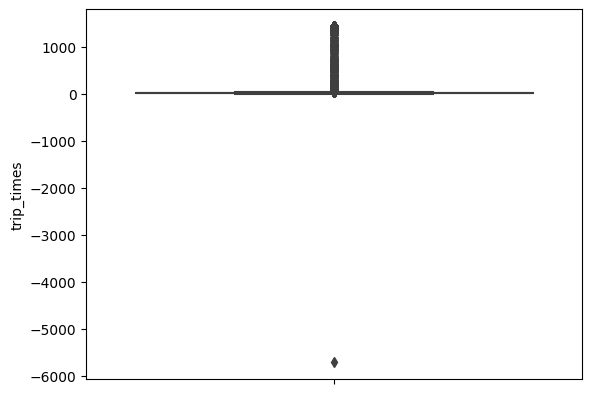

In [13]:
sns.boxplot(y="trip_times", data =frame_with_durations)
plt.show()

In [14]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is -5711.583333333333
10 percentile value is 3.85
20 percentile value is 5.383333333333334
30 percentile value is 6.816666666666666
40 percentile value is 8.3
50 percentile value is 9.933333333333334
60 percentile value is 11.833333333333334
70 percentile value is 14.183333333333334
80 percentile value is 17.416666666666668
90 percentile value is 22.8
100 percentile value is  1439.9833333333333


In [15]:
#looking further from the 99th percecntile
for i in range(90,100):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 22.8
91 percentile value is 23.616666666666667
92 percentile value is 24.516666666666666
93 percentile value is 25.566666666666666
94 percentile value is 26.766666666666666
95 percentile value is 28.2
96 percentile value is 30.016666666666666
97 percentile value is 32.45
98 percentile value is 36.13333333333333
99 percentile value is 43.81666666666667
100 percentile value is  1439.9833333333333


In [16]:
# 99 percentile value
trip_times_diffusion = var[int(len(var)*(float(99)/100))]

for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    tmp = var[int(len(var)*(float(99+i)/100))]
    if trip_times_diffusion * 10 < tmp:
        trip_times_diffusion = var[int(len(var)*(float(99+i-0.1)/100))] * 2
        print(f"{99+i} percentile is diffusion value. So we set outline value {99+i-0.1} percentile value X 2: {trip_times_diffusion}")
        break
    print("{} percentile value is {}".format(99+i,tmp))
print("100 percentile value is ",var[-1])

99.0 percentile value is 43.81666666666667
99.1 percentile value is 45.2
99.2 percentile value is 46.86666666666667
99.3 percentile value is 48.93333333333333
99.4 percentile value is 51.516666666666666
99.5 percentile value is 54.95
99.6 percentile value is 60.03333333333333
99.7 percentile value is 68.0
99.8 percentile value is 90.38333333333334
99.9 percentile is diffusion value. So we set outline value 99.80000000000001 percentile value X 2: 180.76666666666668
100 percentile value is  1439.9833333333333


In [17]:
#removing data based on our analysis and TLC regulations
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_times>1) & (frame_with_durations.trip_times<trip_times_diffusion)]

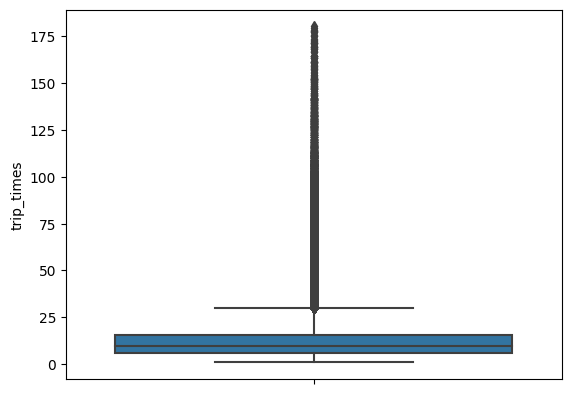

In [18]:
#box-plot after removal of outliers
sns.boxplot(y="trip_times", data =frame_with_durations_modified)
plt.show()

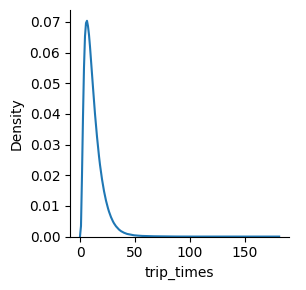

In [19]:
#pdf of trip-times after removing the outliers
sns.FacetGrid(frame_with_durations_modified).map(sns.kdeplot,"trip_times").add_legend()
plt.show()

In [20]:
#converting the values to log-values to chec for log-normal
import math
frame_with_durations_modified['log_times']=[math.log(i) for i in frame_with_durations_modified['trip_times'].values]

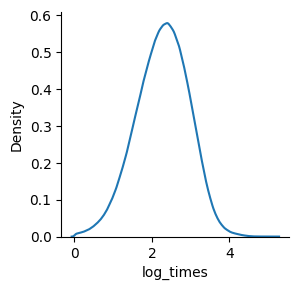

In [21]:
#pdf of log-values
sns.FacetGrid(frame_with_durations_modified) \
      .map(sns.kdeplot,"log_times") \
      .add_legend()
plt.show()


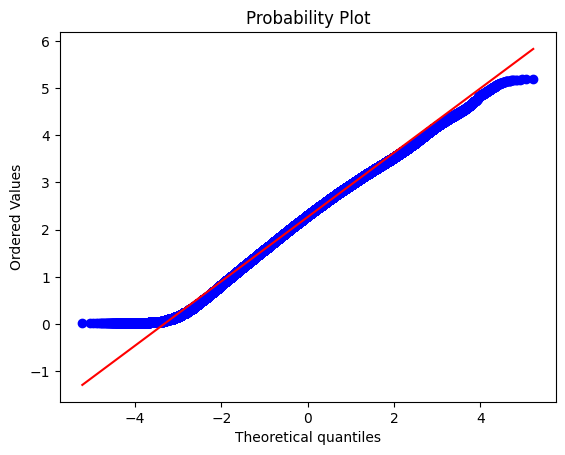

In [22]:
#Q-Q plot for checking if trip-times is log-normal
import scipy
scipy.stats.probplot(frame_with_durations_modified['log_times'].values, plot=plt)
plt.show()

`scipy.stats.probplot`은 데이터의 분포도를 나타낸다.

## 2-2. Speed

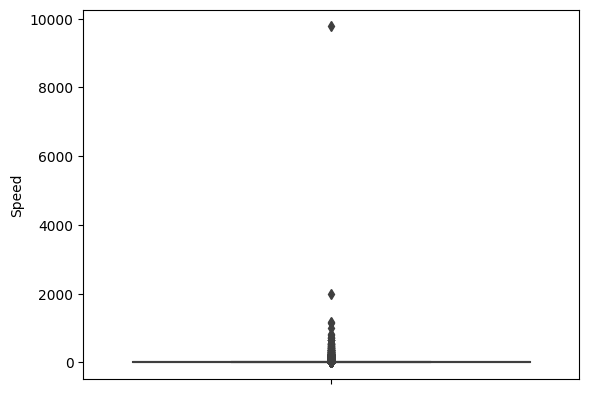

In [23]:
# check for any outliers in the data after trip duration outliers removed
# box-plot for speeds with outliers
frame_with_durations_modified['Speed'] = 60*(frame_with_durations_modified['trip_distance']/frame_with_durations_modified['trip_times'])
sns.boxplot(y="Speed", data =frame_with_durations_modified)
plt.show()

In [24]:
#calculating speed values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 5.669291338582677
20 percentile value is 6.881720430107528
30 percentile value is 7.848101265822786
40 percentile value is 8.758389261744966
50 percentile value is 9.696275071633238
60 percentile value is 10.741793238608524
70 percentile value is 12.0
80 percentile value is 13.764705882352942
90 percentile value is 16.89650626235992
100 percentile value is  9774.117647058823


In [25]:
#calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 16.89650626235992
91 percentile value is 17.40192926045016
92 percentile value is 17.99043062200957
93 percentile value is 18.647482014388487
94 percentile value is 19.442508710801395
95 percentile value is 20.403269754768395
96 percentile value is 21.607084289931123
97 percentile value is 23.188028627195838
98 percentile value is 25.376641326883206
99 percentile value is 29.027303754266207
100 percentile value is  9774.117647058823


In [26]:
#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    if i == 0.9:
        speed_99_9 = var[int(len(var)*(float(99+i)/100))]
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 29.027303754266207
99.1 percentile value is 29.577464788732396
99.2 percentile value is 30.187110187110182
99.3 percentile value is 30.874715261958997
99.4 percentile value is 31.656370656370655
99.5 percentile value is 32.54237288135593
99.6 percentile value is 33.607250755287005
99.7 percentile value is 34.95603367633302
99.8 percentile value is 36.747252747252745
99.9 percentile value is 39.55748031496063
100 percentile value is  9774.117647058823


In [27]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.Speed>0) & (frame_with_durations.Speed<=speed_99_9)]

In [28]:
#avg.speed of cabs in New-York
sum(frame_with_durations_modified["Speed"]) / float(len(frame_with_durations_modified["Speed"]))

10.69346116566279

## 2-3. Trip Distance

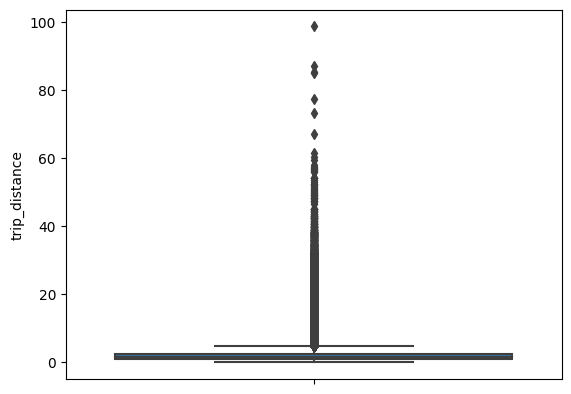

In [29]:
# up to now we have removed the outliers based on trip durations and cab speeds
# lets try if there are any outliers in trip distances
# box-plot showing outliers in trip-distance values
sns.boxplot(y="trip_distance", data =frame_with_durations_modified)
plt.show()

In [30]:
#calculating trip distance values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.01
10 percentile value is 0.6
20 percentile value is 0.8
30 percentile value is 1.0
40 percentile value is 1.2
50 percentile value is 1.49
60 percentile value is 1.8
70 percentile value is 2.2
80 percentile value is 2.9
90 percentile value is 4.5
100 percentile value is  98.7


In [31]:
#calculating trip distance values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 4.5
91 percentile value is 4.8
92 percentile value is 5.1
93 percentile value is 5.5
94 percentile value is 6.0
95 percentile value is 6.58
96 percentile value is 7.35
97 percentile value is 8.56
98 percentile value is 10.13
99 percentile value is 13.8
100 percentile value is  98.7


In [32]:
#calculating trip distance values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    if i ==0.9:
        trip_distance_99_9 = var[int(len(var)*(float(99+i)/100))]
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 13.8
99.1 percentile value is 14.85
99.2 percentile value is 15.9
99.3 percentile value is 16.5
99.4 percentile value is 16.93
99.5 percentile value is 17.3
99.6 percentile value is 17.7
99.7 percentile value is 18.3
99.8 percentile value is 19.29
99.9 percentile value is 20.7
100 percentile value is  98.7


In [33]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_distance>0) & (frame_with_durations.trip_distance<=trip_distance_99_9)]

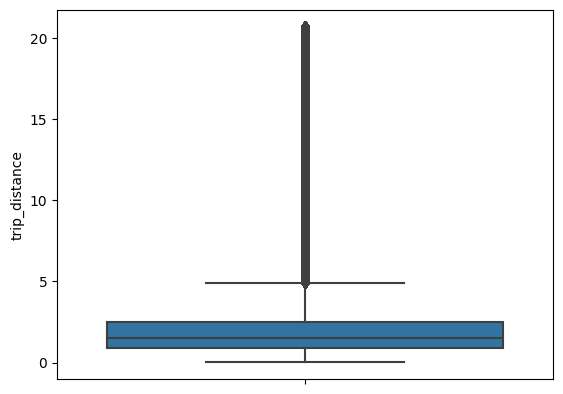

In [34]:
#box-plot after removal of outliers
sns.boxplot(y="trip_distance", data = frame_with_durations_modified)
plt.show()

## 2-4. Total Fare

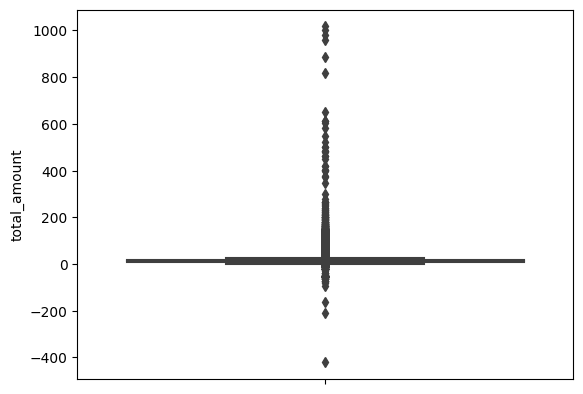

In [35]:
# up to now we have removed the outliers based on trip durations, cab speeds, and trip distances
# lets try if there are any outliers in based on the total_amount
# box-plot showing outliers in fare
sns.boxplot(y="total_amount", data =frame_with_durations_modified)
plt.show()

In [36]:
#calculating total fare amount values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -420.8
10 percentile value is 6.36
20 percentile value is 7.56
30 percentile value is 8.76
40 percentile value is 9.8
50 percentile value is 11.0
60 percentile value is 12.35
70 percentile value is 14.16
80 percentile value is 17.0
90 percentile value is 22.3
100 percentile value is  1017.3


In [37]:
#calculating total fare amount values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 22.3
91 percentile value is 23.16
92 percentile value is 24.3
93 percentile value is 25.55
94 percentile value is 26.8
95 percentile value is 28.8
96 percentile value is 31.3
97 percentile value is 35.3
98 percentile value is 41.95
99 percentile value is 54.56
100 percentile value is  1017.3


In [38]:
#calculating total fare amount values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 54.56
99.1 percentile value is 57.8
99.2 percentile value is 58.56
99.3 percentile value is 62.06
99.4 percentile value is 63.56
99.5 percentile value is 68.56
99.6 percentile value is 70.27
99.7 percentile value is 71.17
99.8 percentile value is 75.8
99.9 percentile value is 90.8
100 percentile value is  1017.3


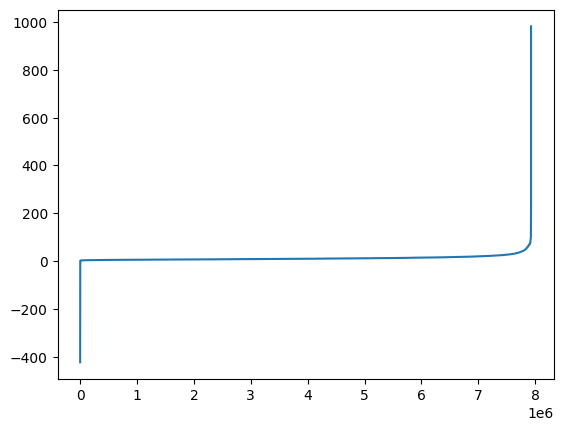

In [39]:
#below plot shows us the fare values(sorted) to find a sharp increase to remove those values as outliers
# plot the fare amount excluding last two values in sorted data
plt.plot(var[:-2])
plt.show()

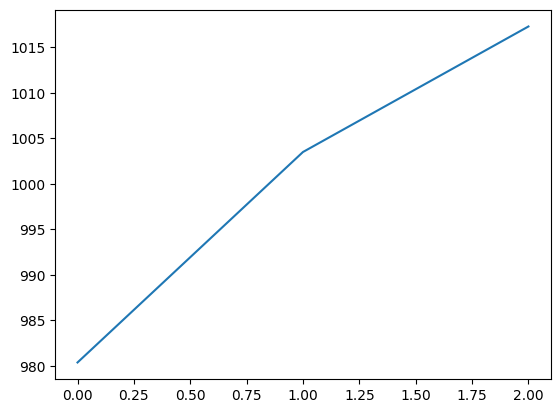

In [40]:
# a very sharp increase in fare values can be seen 
# plotting last three total fare values, and we can observe there is share increase in the values
plt.plot(var[-3:])
plt.show()

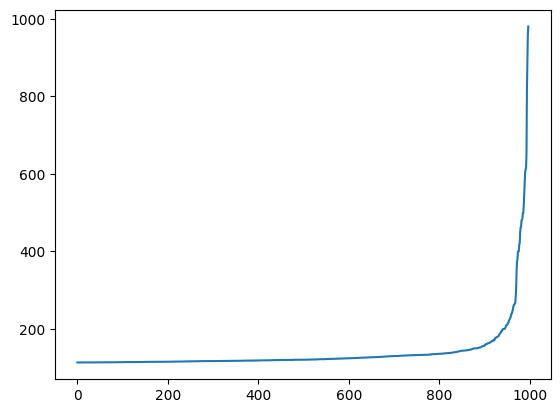

In [41]:
# we plot last 50 values excluding last two values
plt.plot(var[-1000:-2])
plt.show()

In [42]:
total_amount_diffusion = 300

300 부근에서 값이 튄다.

## Remove all outliers/erronous points

In [43]:
def map_region(dataframe, region):
    region_df = taxi_zone_df[taxi_zone_df['Borough'] == region]
    region_number = region_df['LocationID']
    
    region_arr_data = []
    for i in region_number.values:
        region_arr_data.append(dataframe[dataframe['PULocationID'] == i])
    
    region_df = pd.concat(region_arr_data, axis=0, ignore_index=True)

    return region_df
    

In [44]:
#removing all outliers based on our univariate analysis above
def remove_outliers(new_frame):

    
    # a = new_frame.shape[0]
    # print ("Number of pickup records = ",a)
    
    # temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    # c = temp_frame.shape[0]
    # print ("Number of outliers from trip times analysis:",(a-c))
    
    
    # temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 25.52)]
    # d = temp_frame.shape[0]
    # print ("Number of outliers from trip distance analysis:",(a-d))
    
    # temp_frame = new_frame[(new_frame.Speed <= 45.28) & (new_frame.Speed >= 0)]
    # e = temp_frame.shape[0]
    # print ("Number of outliers from speed analysis:",(a-e))
    
    # temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    # f = temp_frame.shape[0]
    # print ("Number of outliers from fare analysis:",(a-f))
    
    new_frame = new_frame[(new_frame.total_amount > 0) & (new_frame.total_amount <total_amount_diffusion)]
    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < trip_times_diffusion)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance <= trip_distance_99_9)]
    new_frame = new_frame[(new_frame.Speed > 0) & (new_frame.Speed <= speed_99_9)]


    
    
    # print ("Total outliers removed",a - new_frame.shape[0])
    # print ("---")
    return new_frame

In [45]:
print (f"Removing outliers in the month of Jan-{base_year}")
print ("----")
frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
print("fraction of data points that remain after removing outliers", float(len(frame_with_durations_outliers_removed))/len(frame_with_durations))

Removing outliers in the month of Jan-2018
----
fraction of data points that remain after removing outliers 0.9914485164917791


In [46]:
frame_with_durations_outliers_removed.head()

passenger_count  trip_distance  PULocationID  DOLocationID  total_amount  \
0                4            0.7             4           232          6.30   
1                1            0.8             4           148          9.55   
2                2            1.1             4           224          7.30   
3                1            0.9             4           232          7.80   
4                1            2.9             4            68         15.80   

   trip_times  pickup_times      Speed  
0    4.716667  1.514733e+09   8.904594  
1    8.566667  1.514735e+09   5.603113  
2    5.716667  1.514736e+09  11.545190  
3    7.700000  1.514734e+09   7.012987  
4   20.283333  1.514734e+09   8.578472

In [47]:
frame_with_durations_outliers_removed['PULocationID'].value_counts()

237    358980
161    352193
236    343796
162    305895
230    305865
        ...  
194       219
153        83
128        46
120        37
105         7
Name: PULocationID, Length: 67, dtype: int64

## Data-preperation

## Time-binning

In [48]:
def set_unixtimestamp():
    unix_times = []
    for year in range(2):
        tmp = []
        for i in range(1,base_month_count+1):
            date_time = datetime.datetime(base_year+year, i, 1, 0, 0)
            tmp.append(int(time.mktime(date_time.timetuple())))
        unix_times.append(tmp)
    return unix_times

In [49]:
print(set_unixtimestamp())

[[1514732400, 1517410800, 1519830000], [1546268400, 1548946800, 1551366000]]


In [50]:
def add_pickup_bins(frame,month,year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]

    unix_times = set_unixtimestamp()
    
    start_pickup_unix=unix_times[year-base_year][month-1]

    # https://www.timeanddate.com/time/zones/est
    # (int((i-start_pickup_unix)/600)+33) : our unix time is in gmt to we are converting it to est
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [51]:
jan_base_year_frame = add_pickup_bins(frame_with_durations_outliers_removed,1,base_year)

jan_base_year_groupby = jan_base_year_frame[['PULocationID','pickup_bins','trip_distance']].groupby(['PULocationID','pickup_bins']).count()

In [52]:
jan_base_year_frame.head()

passenger_count  trip_distance  PULocationID  DOLocationID  total_amount  \
0                4            0.7             4           232          6.30   
1                1            0.8             4           148          9.55   
2                2            1.1             4           224          7.30   
3                1            0.9             4           232          7.80   
4                1            2.9             4            68         15.80   

   trip_times  pickup_times      Speed  pickup_bins  
0    4.716667  1.514733e+09   8.904594           33  
1    8.566667  1.514735e+09   5.603113           36  
2    5.716667  1.514736e+09  11.545190           38  
3    7.700000  1.514734e+09   7.012987           35  
4   20.283333  1.514734e+09   8.578472           36

In [69]:
test_frame = jan_base_year_frame[['PULocationID','pickup_bins']]
now = 3732
after_frame = test_frame.loc[(test_frame['pickup_bins'] <now) & (test_frame['pickup_bins']>=now-5)]
after_frame


PULocationID  pickup_bins
15875               4         3727
15880               4         3728
15881               4         3729
15885               4         3727
15890               4         3727
...               ...          ...
7936154           263         3731
7936159           263         3730
7936161           263         3730
7936168           263         3729
7936169           263         3730

[12178 rows x 2 columns]

In [103]:
# for i in range(1, 2): ## 1~5번째 전 bin의 탑승 수를 맨해튼 모든 지역별로 돌려서 저장 
# ft_1이 10분 전
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']

for i in nyc_region_number.values:
    temp_list = [0 for i in range(5)]
    temp1_frame = after_frame.loc[(after_frame['PULocationID']==i)]
    globals()['region_{}_frame'.format(i)] = pd.DataFrame(columns = columns)
    for j in range(1,6):
        temp2_frame = temp1_frame.loc[(temp1_frame['pickup_bins'] == now-j)]
        temp_list[5-j] = len(temp2_frame)
        globals()['region_{}_bins_{}'.format(i, j)] = len(temp2_frame)
    eval('region_' + str(i) + '_frame').loc[0] = temp_list


In [111]:
region_12_frame

ft_5  ft_4  ft_3  ft_2  ft_1
0     3     1     1     3     0

In [113]:
region_4_frame

ft_5  ft_4  ft_3  ft_2  ft_1
0     4     2     2     3     2

In [112]:

for i in nyc_region_number.values:
    print('region = {0}'.format(i))
    for j in range(1, 6):
        print(eval('region_'+str(i)+'_bins_'+str(j)))

region = 4
2
3
2
2
4
region = 12
0
3
1
1
3
region = 13
29
27
33
21
28
region = 24
10
12
12
8
13
region = 41
11
11
10
9
7
region = 42
5
4
6
1
4
region = 43
54
59
59
60
58
region = 45
10
4
11
7
8
region = 48
76
44
49
59
46
region = 50
11
19
17
17
19
region = 68
65
73
66
50
54
region = 74
7
12
1
9
14
region = 75
9
13
20
23
15
region = 79
39
30
48
42
55
region = 87
23
15
13
19
14
region = 88
12
14
15
11
7
region = 90
46
53
70
55
38
region = 100
32
50
68
48
48
region = 103
0
0
0
0
0
region = 104
0
0
0
0
0
region = 105
0
0
0
0
0
region = 107
54
64
45
51
61
region = 113
28
34
38
46
43
region = 114
26
28
26
33
23
region = 116
0
2
2
3
6
region = 120
0
0
1
0
0
region = 125
11
15
9
12
14
region = 127
0
1
1
1
0
region = 128
0
1
0
0
0
region = 137
37
40
45
40
46
region = 140
51
55
68
59
67
region = 141
61
51
53
68
63
region = 142
99
79
76
93
87
region = 143
35
24
33
36
39
region = 144
13
27
24
25
21
region = 148
14
12
17
8
15
region = 151
18
28
21
28
26
region = 152
1
6
1
0
3
region = 153
0
0
0
0
0

In [90]:
js_frame = after_frame.loc[(after_frame['PULocationID']==4)]
ym_frame = js_frame.loc[(js_frame['pickup_bins'] == 3727)]
ym_frame
# print(len(ym_frame))

PULocationID  pickup_bins
15875             4         3727
15885             4         3727
15890             4         3727
15891             4         3727

In [61]:
jan_base_year_groupby.head(10)

trip_distance
PULocationID pickup_bins               
4            33                       8
             34                      13
             35                      18
             36                      18
             37                       7
             38                      21
             39                      19
             40                      26
             41                      29
             42                      32

In [62]:
def datapreparation(month,month_no,year_no):
    
    print(f"start {month_no} month ..")

    print ("Return with trip times..")
    new_frame = map_region(month, region)

    frame_with_durations = return_with_trip_times(new_frame)
    
    print ("Remove outliers..")
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)

    print ("Final groupbying..")
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed,month_no,year_no)
    final_groupby_frame = final_updated_frame[['PULocationID','pickup_bins','trip_distance']].groupby(['PULocationID','pickup_bins']).count()
    
    return final_updated_frame,final_groupby_frame

read_months = []
for i in range(1,base_month_count+1):
    if i < 10:
        read_months.append(pd.read_parquet(f'./yellow_tripdata_{base_year+1}-0{i}.parquet',engine='pyarrow'))
    else:
        read_months.append(pd.read_parquet(f'./yellow_tripdata_{base_year+1}-{i}.parquet',engine='pyarrow'))


months_frame = []
months_groupby = []
for index, month in enumerate(read_months):
    tmp_frame, tmp_groupby = datapreparation(month, index+1,base_year+1)
    months_frame.append(tmp_frame)
    months_groupby.append(tmp_groupby)

start 1 month ..
Return with trip times..
Remove outliers..
Final groupbying..
start 2 month ..
Return with trip times..
Remove outliers..
Final groupbying..
start 3 month ..
Return with trip times..
Remove outliers..
Final groupbying..


## Smoothing

In [63]:
# number of 10min indices for jan 2019= 24*31*60/10 = max_pickup_bins_len
interval = 10
days = [31,29,31,30,31,30,31,31,30,31,30,31]
pickup_bins_len = []

for day in days:
    pickup_bins_len.append(int(24*60*day/interval))
max_pickup_bins_len = max(pickup_bins_len)
print(max_pickup_bins_len)

4464


In [64]:
def return_unq_pickup_bins(frame):
    values = []
    for i in nyc_region_number.values:
    # for i in range(1,266):
        new = frame[frame['PULocationID'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

In [110]:
nyc_region_number.values

array([  4,  12,  13,  24,  41,  42,  43,  45,  48,  50,  68,  74,  75,
        79,  87,  88,  90, 100, 103, 104, 105, 107, 113, 114, 116, 120,
       125, 127, 128, 137, 140, 141, 142, 143, 144, 148, 151, 152, 153,
       158, 161, 162, 163, 164, 166, 170, 186, 194, 202, 209, 211, 224,
       229, 230, 231, 232, 233, 234, 236, 237, 238, 239, 243, 244, 246,
       249, 261, 262, 263])

In [65]:
# for every month we get all indices of 10min intravels in which atleast one pickup got happened

jan_base_year_unique = return_unq_pickup_bins(jan_base_year_frame)
months_unique = []
for frame in months_frame:
    months_unique.append(return_unq_pickup_bins(frame))

In [66]:
for i in range(1,len(jan_base_year_unique)):

    print("for the ",i,f"th cluster number of {interval} min intavels with zero pickups: ",max_pickup_bins_len - len(set(jan_base_year_unique[i-1])))
    print('-'*60)

for the  1 th cluster number of 10 min intavels with zero pickups:  380
------------------------------------------------------------
for the  2 th cluster number of 10 min intavels with zero pickups:  2900
------------------------------------------------------------
for the  3 th cluster number of 10 min intavels with zero pickups:  375
------------------------------------------------------------
for the  4 th cluster number of 10 min intavels with zero pickups:  298
------------------------------------------------------------
for the  5 th cluster number of 10 min intavels with zero pickups:  143
------------------------------------------------------------
for the  6 th cluster number of 10 min intavels with zero pickups:  569
------------------------------------------------------------
for the  7 th cluster number of 10 min intavels with zero pickups:  281
------------------------------------------------------------
for the  8 th cluster number of 10 min intavels with zero pickups:  

In [67]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add 0 to the smoothed data
# we finally return smoothed data
def fill_missing(count_values,values):
    smoothed_regions=[]
    ind=0
    for r in range(1,nyc_regions_cnt+1):
        smoothed_bins=[]
        for i in range(max_pickup_bins_len):
            if i in values[r-1]:
                smoothed_bins.append(count_values[ind-1])
                ind+=1
            else:
                # TODO
                # smoothed_bins.append(1)
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [68]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add smoothed data (which is calculated based on the methods that are discussed in the above markdown cell)
# we finally return smoothed data
def smoothing(count_values,values):
    smoothed_regions=[] # stores list of final smoothed values of each reigion
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(1,nyc_regions_cnt+1):
        smoothed_bins=[] #stores the final smoothed values
        repeat=0
        for i in range(max_pickup_bins_len):
            if repeat!=0: # prevents iteration for a value which is already visited/resolved
                repeat-=1
                continue
            if i in values[r-1]: #checks if the pickup-bin exists 
                smoothed_bins.append(count_values[ind-1]) # appends the value of the pickup bin if it exists
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,max_pickup_bins_len):
                        if  j not in values[r-1]: #searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                    #Case 1: When we have the last/last few values are found to be missing,hence we have no right-limit here
                        smoothed_value=count_values[ind-1]*1.0/((max_pickup_bins_len-1-i)+2)*1.0                               
                        for j in range(i,max_pickup_bins_len):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(max_pickup_bins_len-1-i)
                        ind-=1
                    else:
                    #Case 2: When we have the missing values between two known values
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: When we have the first/first few values are found to be missing,hence we have no left-limit here
                    right_hand_limit=0
                    for j in range(i,max_pickup_bins_len):
                        if  j not in values[r-1]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [69]:
#Filling Missing values of Jan-2015 with 0
# here in jan_2015_groupby dataframe the trip_distance represents the number of pickups that are happened
jan_base_year_fill = fill_missing(jan_base_year_groupby['trip_distance'].values,jan_base_year_unique)


#Smoothing Missing values of Jan-2015
jan_base_year_smooth = smoothing(jan_base_year_groupby['trip_distance'].values,jan_base_year_unique)


In [70]:
# number of 10min indices for jan 2015= 24*31*60/10 = max_pickup_bins_len
# number of 10min indices for jan 2016 = 24*31*60/10 = max_pickup_bins_len
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*30*60/10 = 4320
# for each cluster we will have max_pickup_bins_len values, therefore 40*max_pickup_bins_len = 178560 (length of the jan_base_year_fill)
print("number of 10min intravels among all the clusters ",len(jan_base_year_fill))

number of 10min intravels among all the clusters  308016


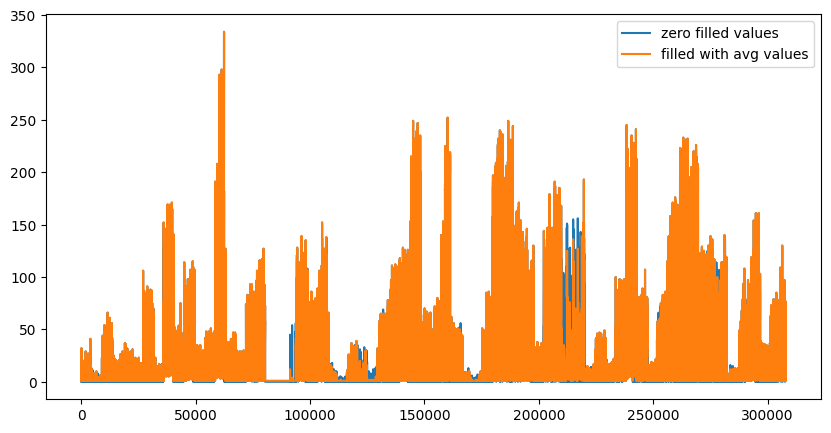

In [71]:
# Smoothing vs Filling
# sample plot that shows two variations of filling missing values
# we have taken the number of pickups for cluster region 2
plt.figure(figsize=(10,5))
plt.plot(jan_base_year_fill[:len(jan_base_year_fill)], label="zero filled values")
plt.plot(jan_base_year_smooth[:len(jan_base_year_fill)], label="filled with avg values")
plt.legend()
plt.show()


In [72]:
jan_base_year_smooth = smoothing(jan_base_year_groupby['trip_distance'].values,jan_base_year_unique)

months_smooth = []
for groupby, unique in zip(months_groupby, months_unique):
    # smoothing을 할 것인가 filling을 할것인가
    months_smooth.append(smoothing(groupby['trip_distance'].values,unique))

# Making list of all the values of pickup data in every bin for a period of 3 months and storing them region-wise 
regions_cum = []


# number of 10min indices for jan 2019= 24*31*60/10 = 4464      # pickup_bins_len[0]
# number of 10min indices for jan 2020 = 24*31*60/10 = 4464     # pickup_bins_len[0]
# number of 10min indices for feb 2020 = 24*29*60/10 = 4176     # pickup_bins_len[1]
# number of 10min indices for march 2020 = 24*31*60/10 = 4464   # pickup_bins_len[2]
# regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups 
# that are happened for three months in 2016 data

# nyc_regions_cnt개의 맨허튼 지역
for i in range(1,nyc_regions_cnt+1):
    cum = []
    for index, smooth in enumerate(months_smooth):
        cum += smooth[pickup_bins_len[index]*(i-1):pickup_bins_len[index]*i]
    regions_cum.append(cum)

print(len(regions_cum))
print(len(regions_cum[0]))


69
13104


## Time series and Fourier Transforms

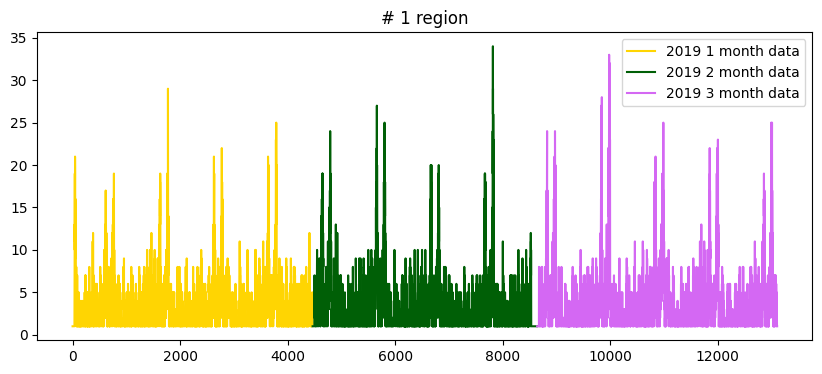

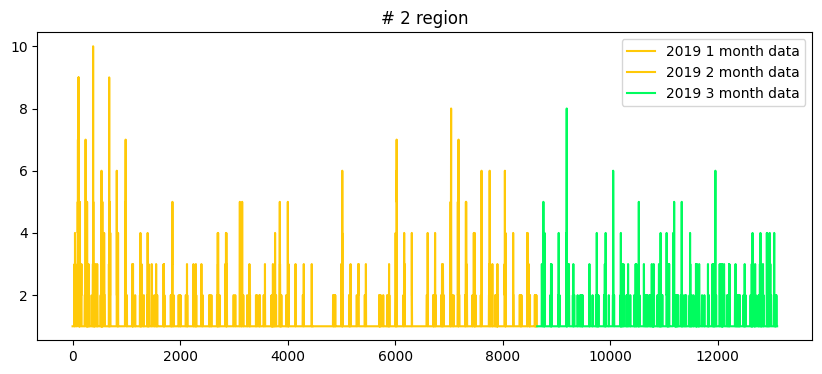

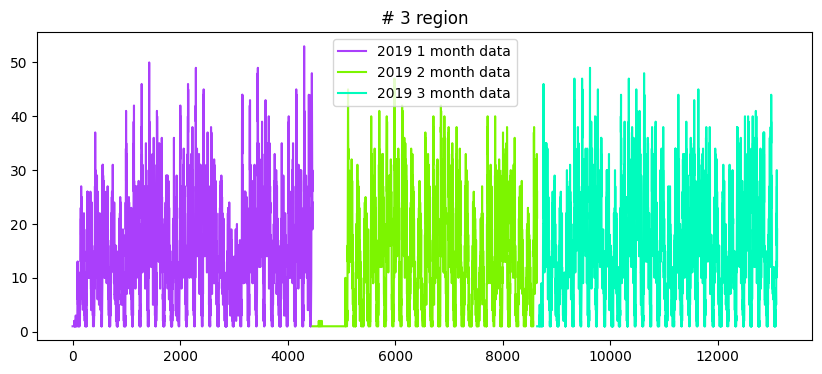

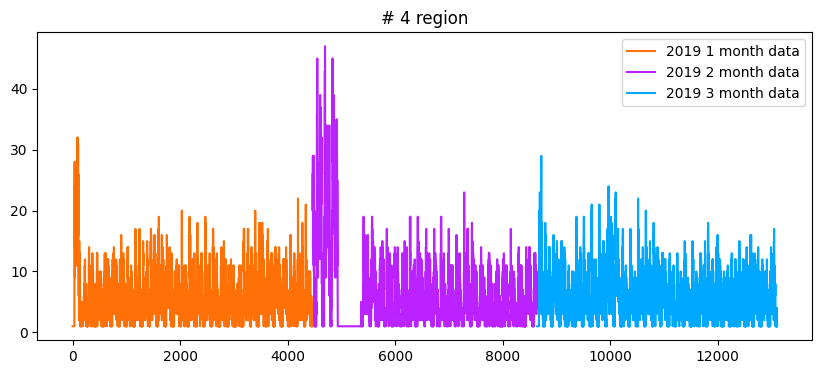

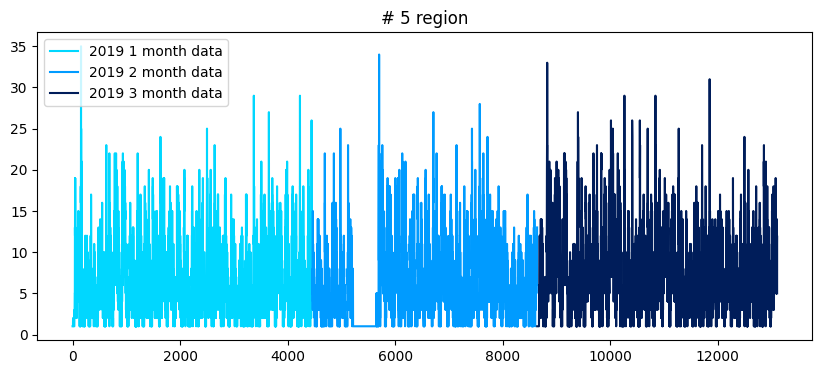

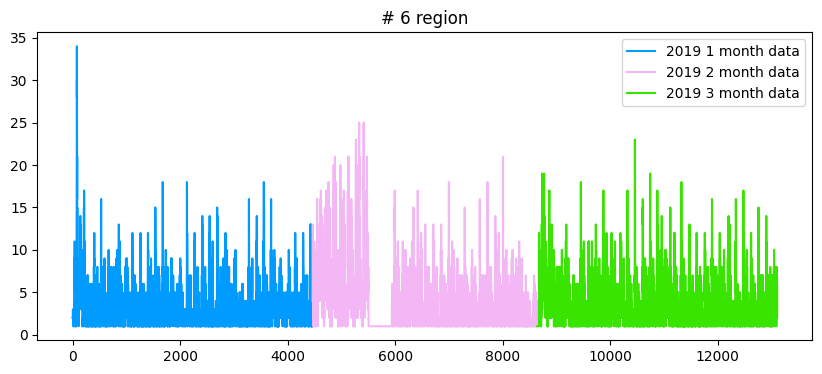

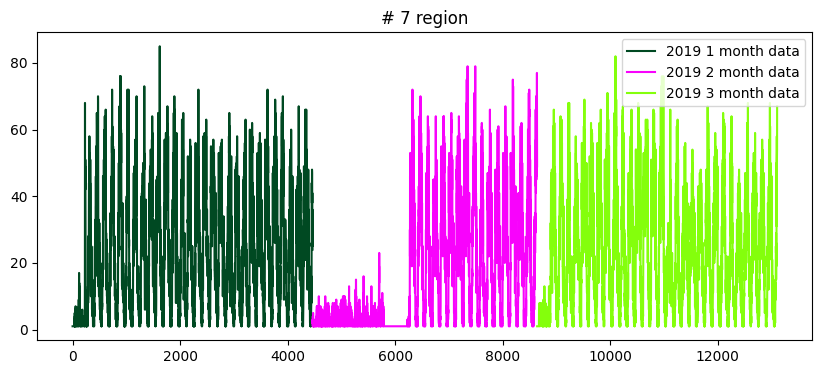

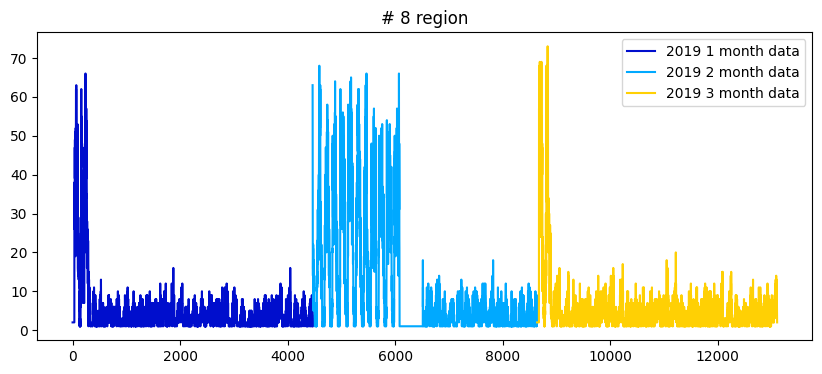

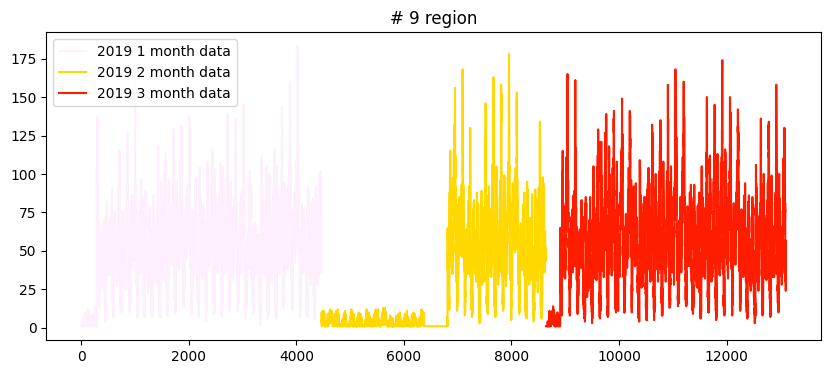

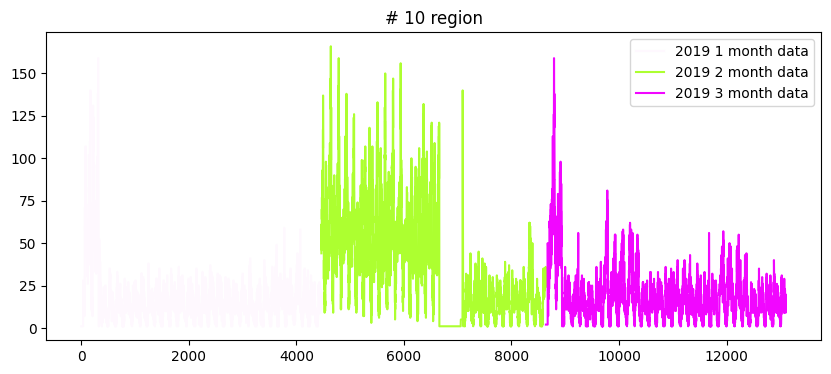

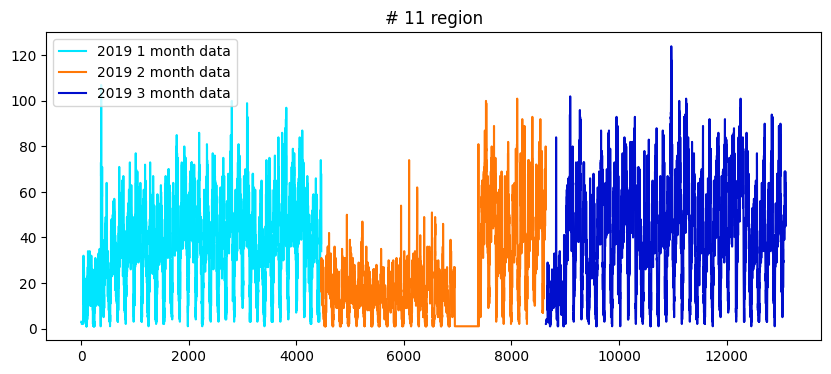

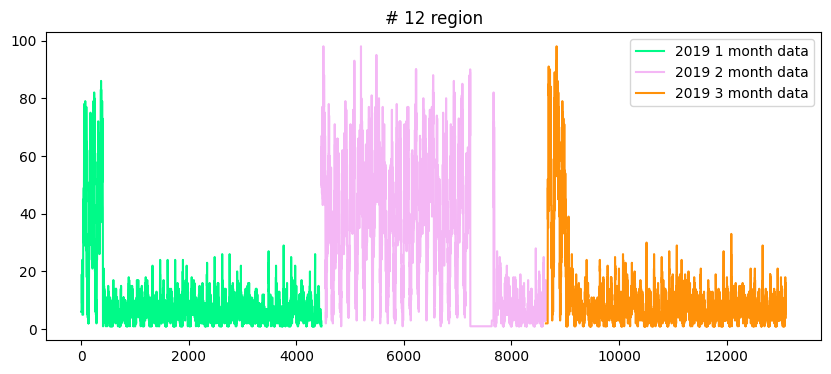

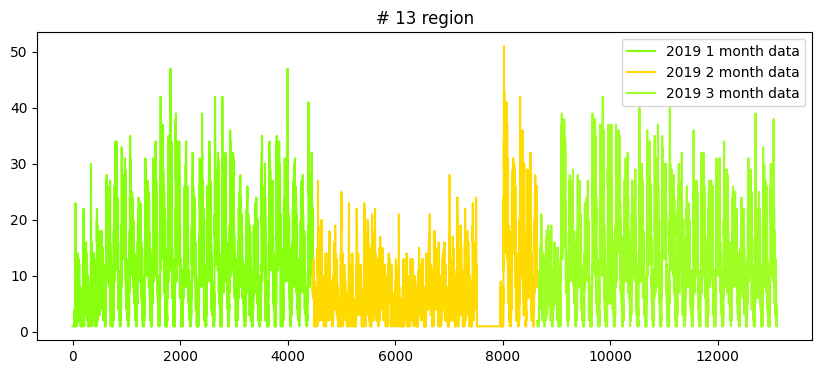

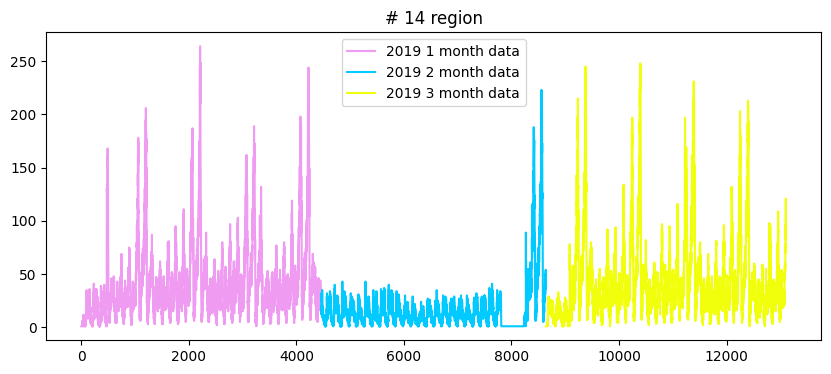

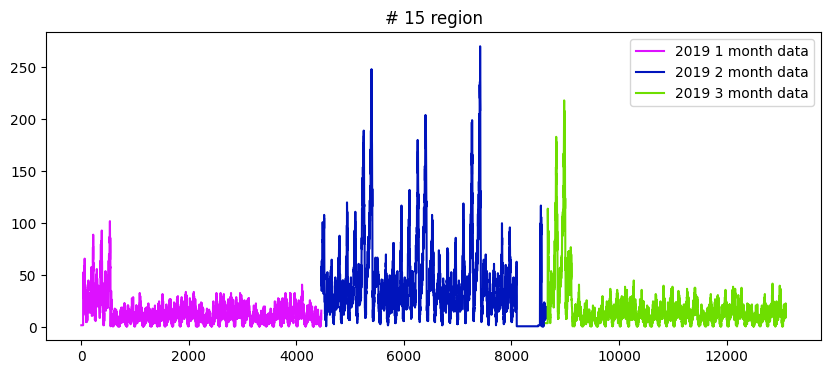

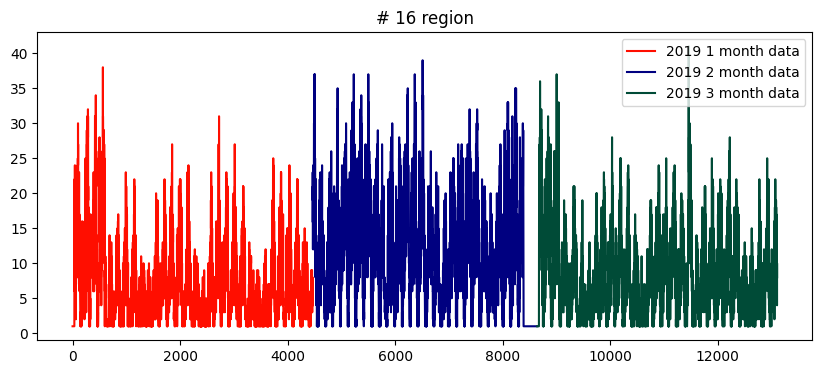

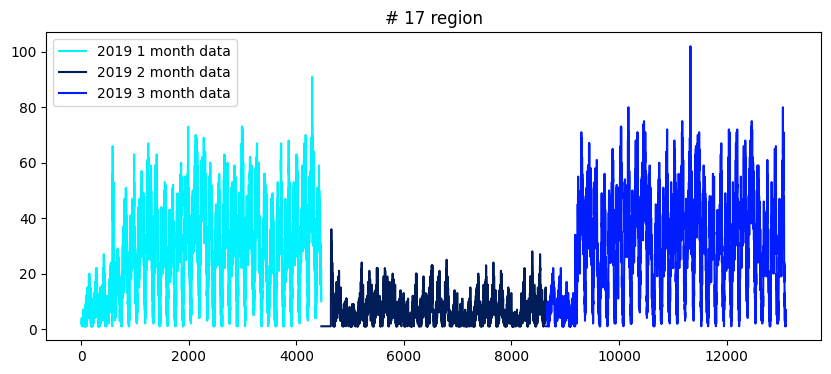

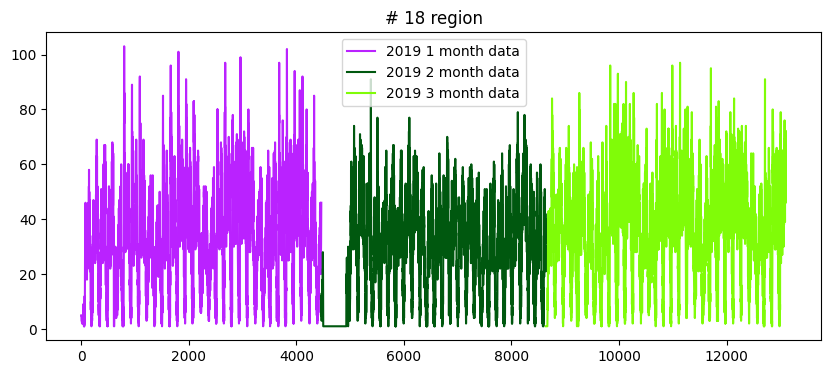

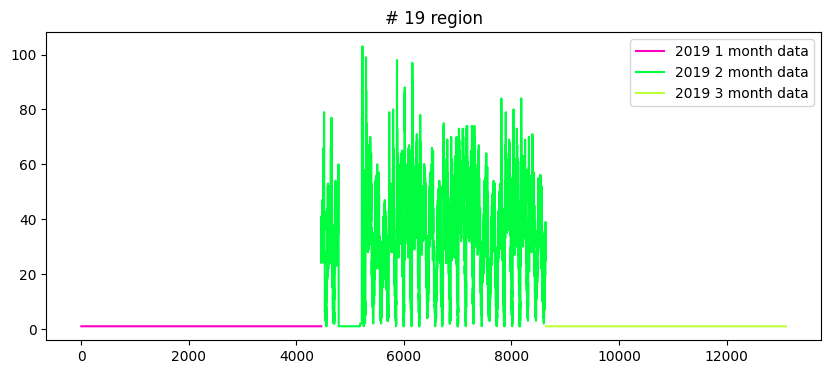

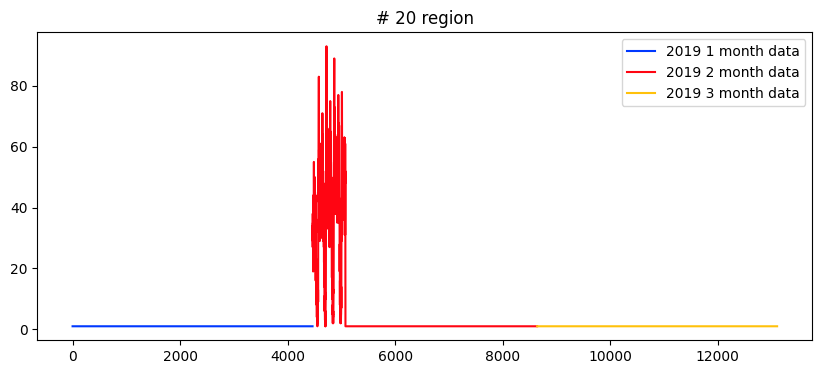

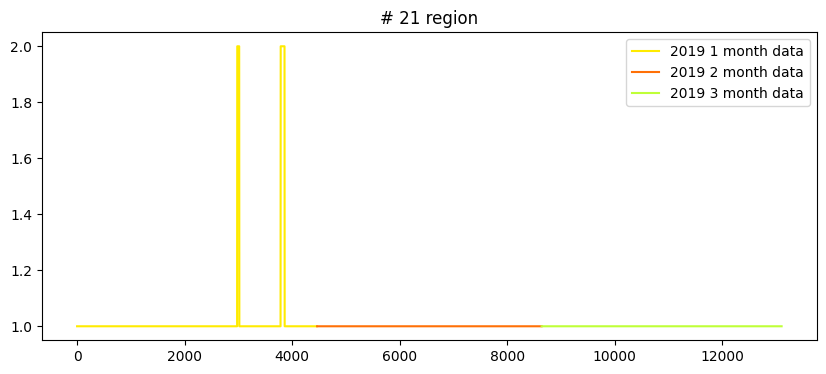

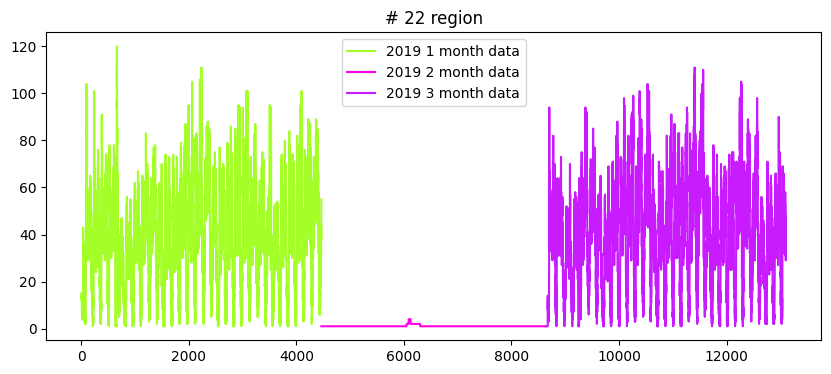

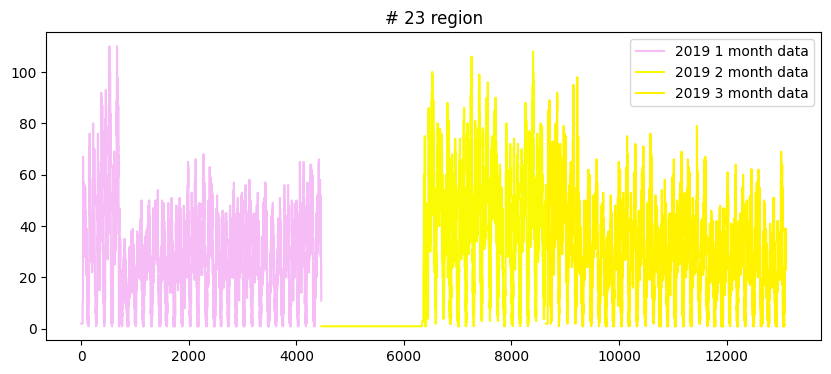

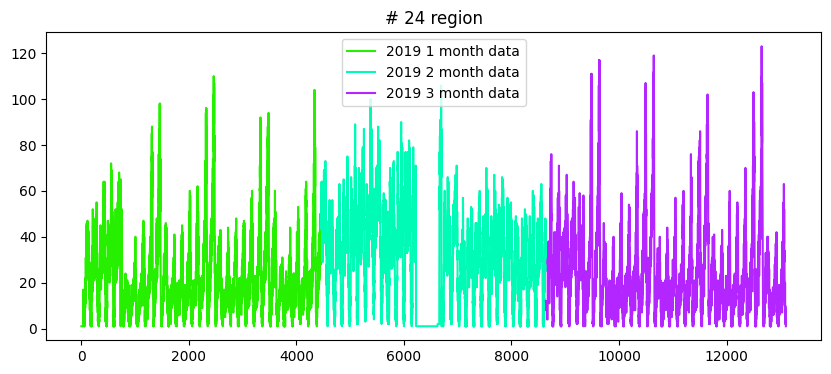

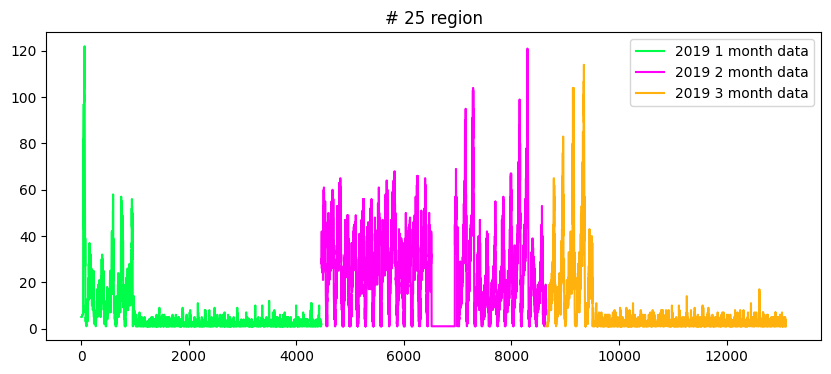

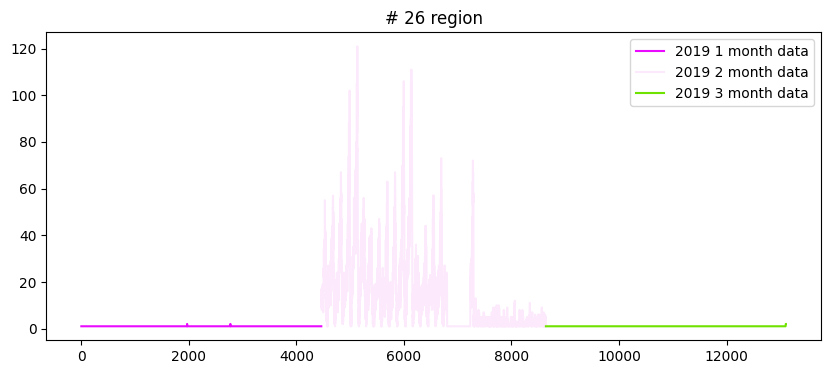

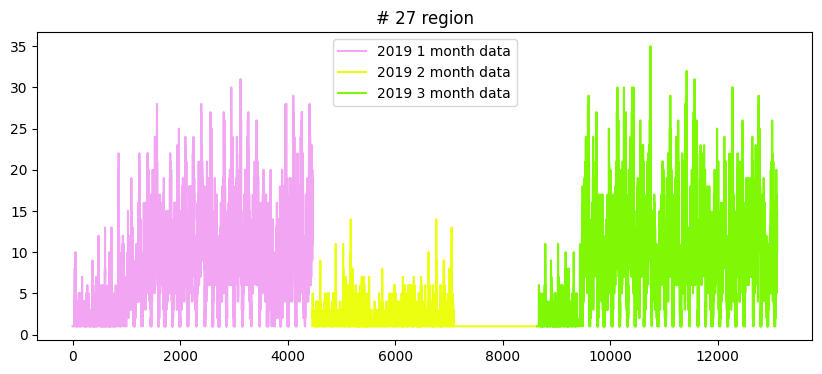

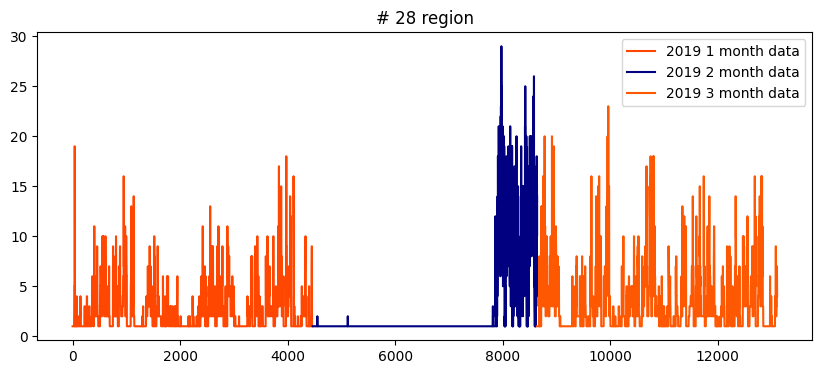

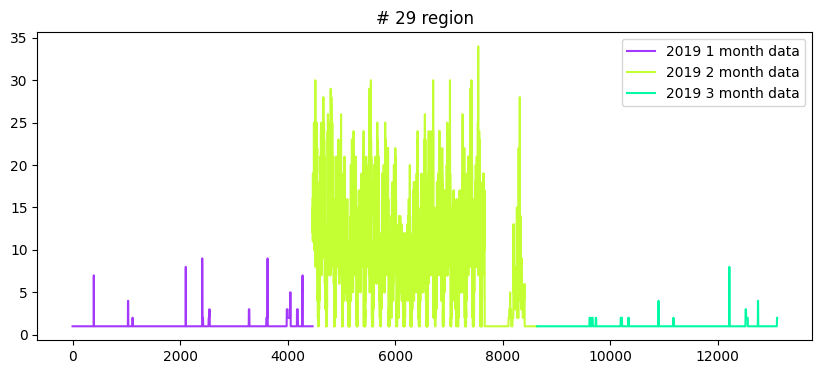

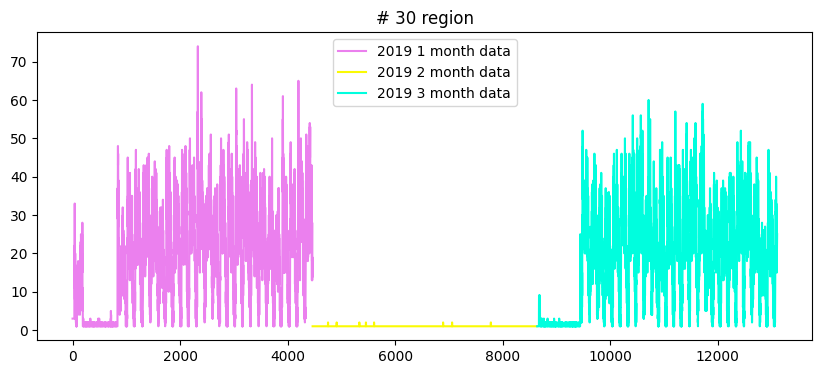

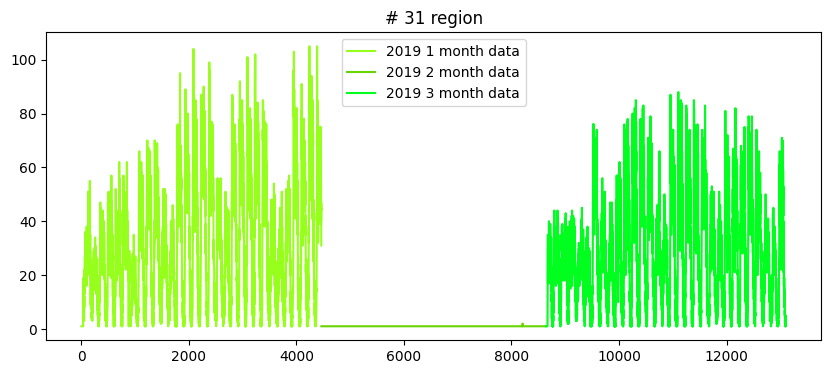

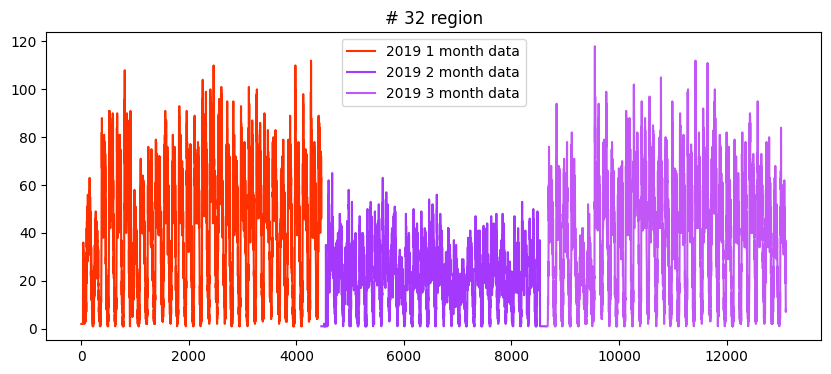

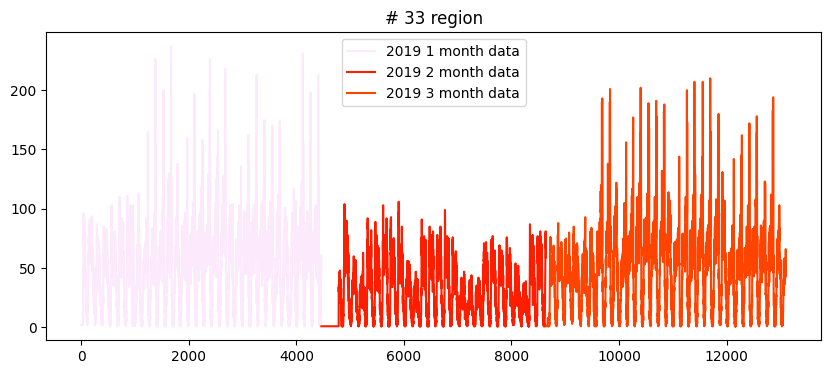

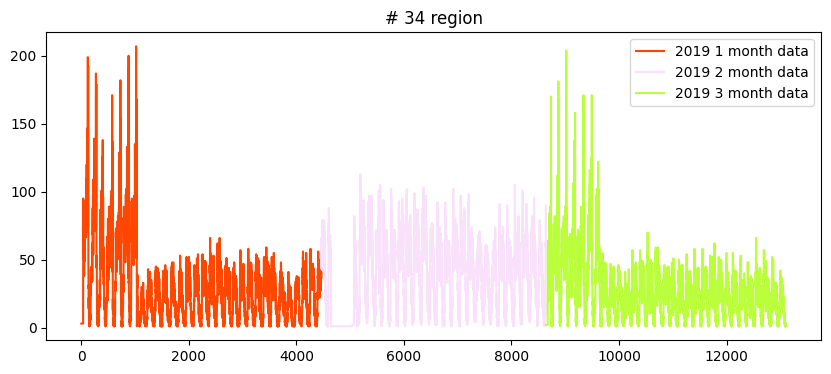

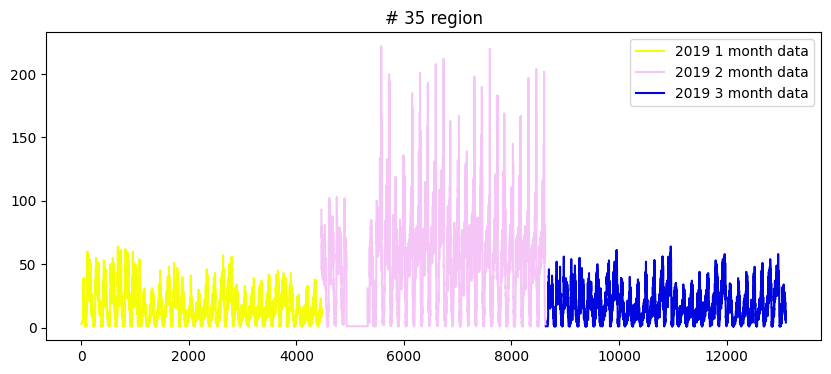

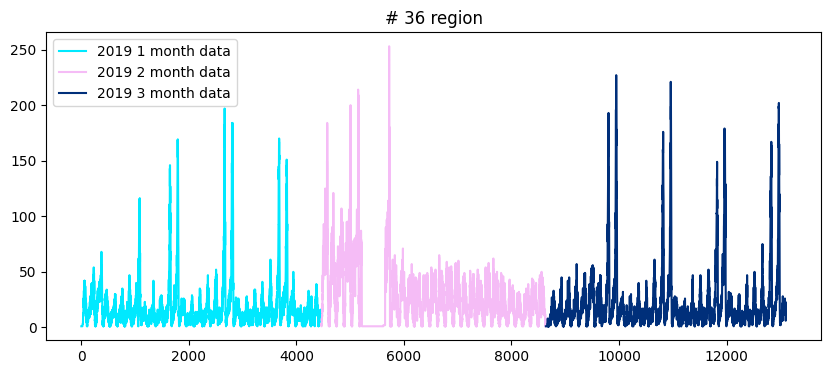

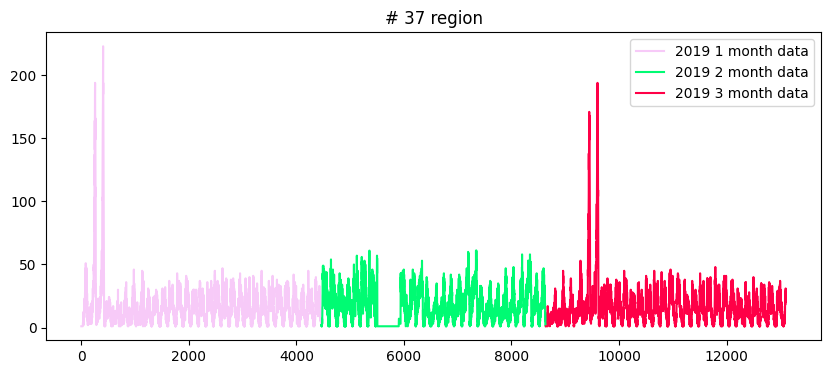

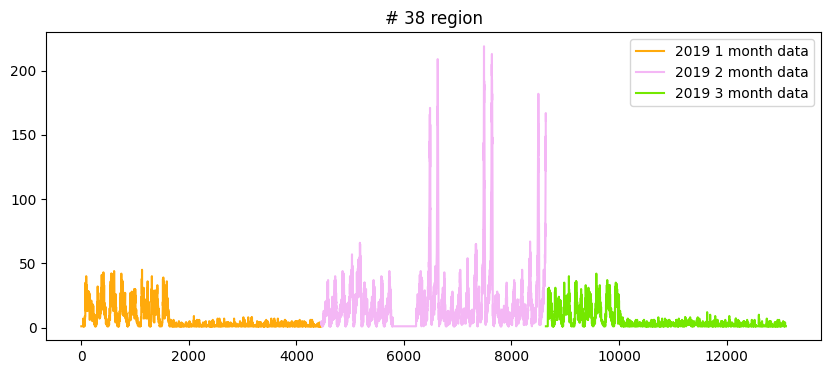

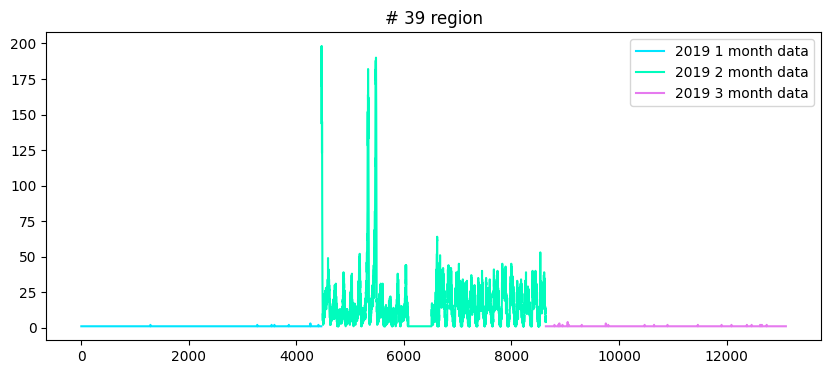

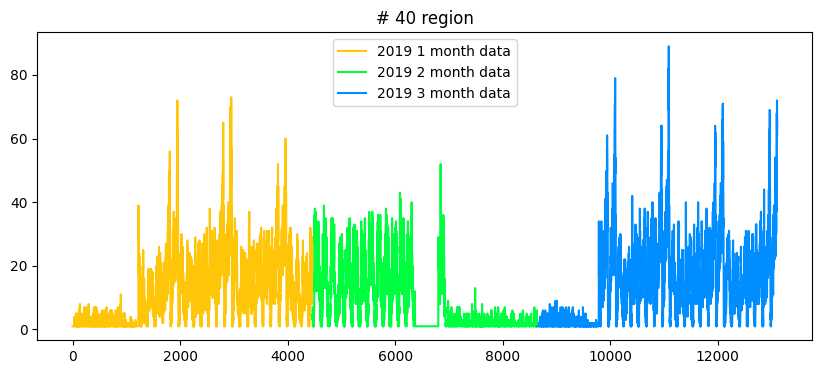

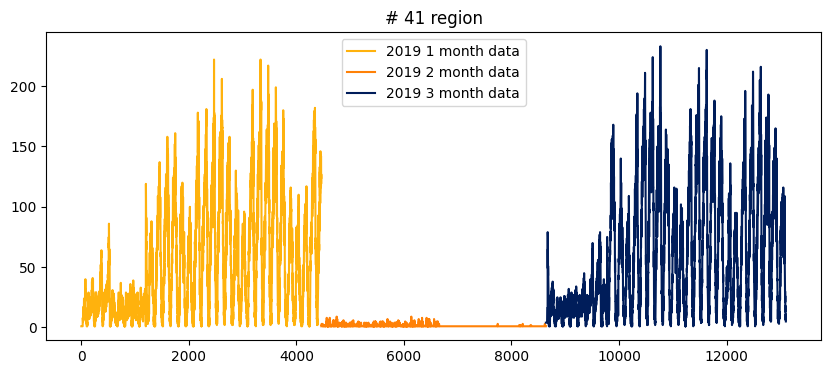

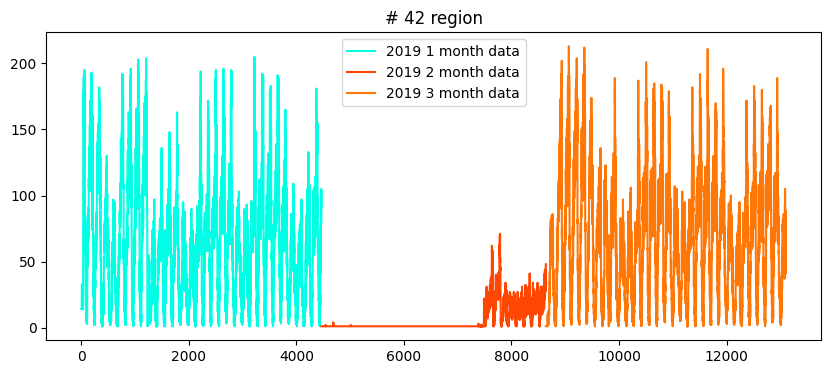

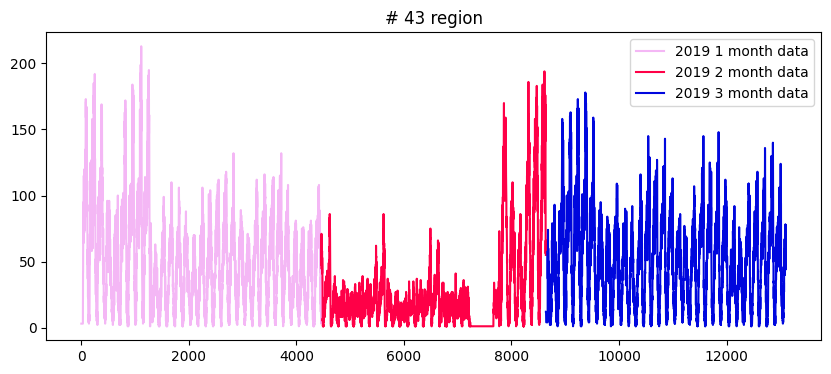

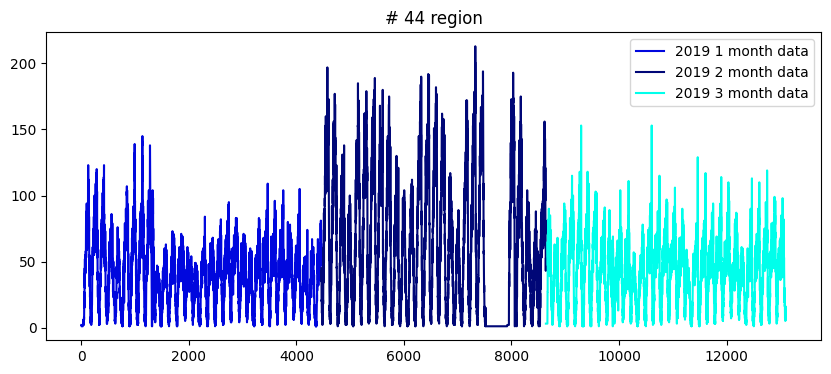

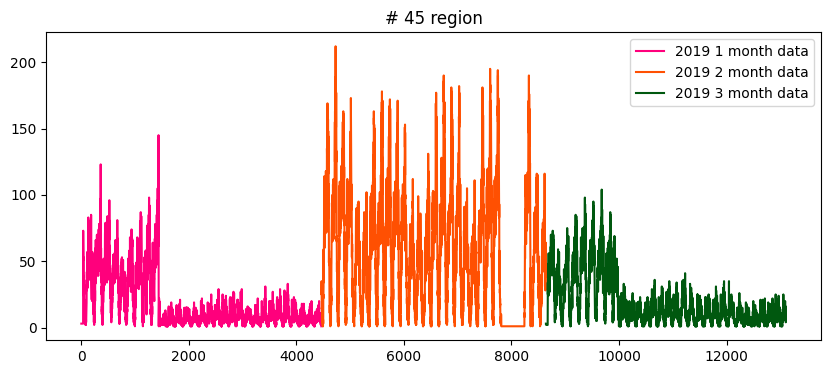

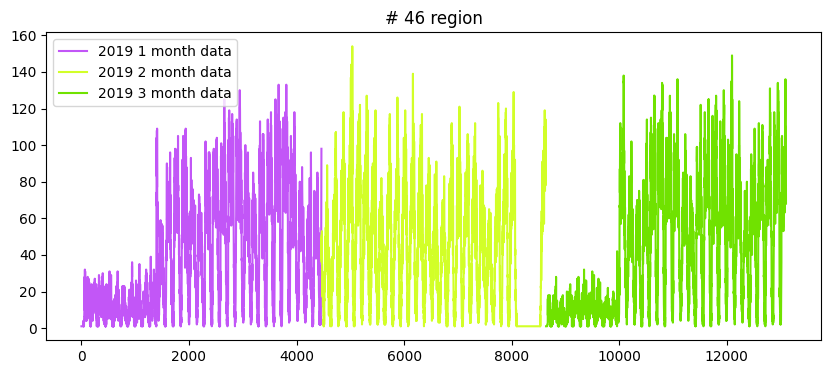

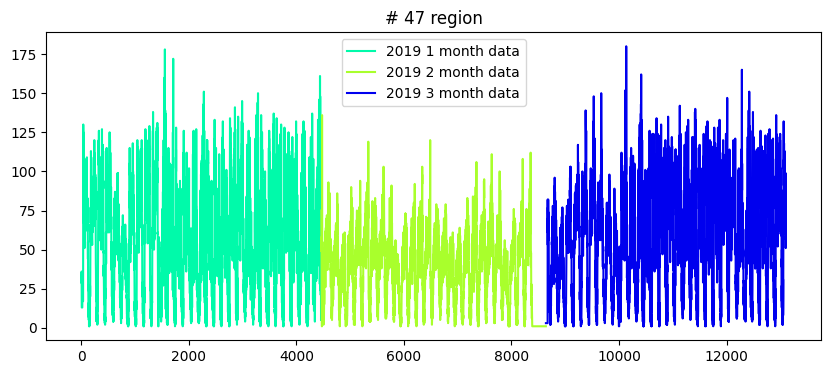

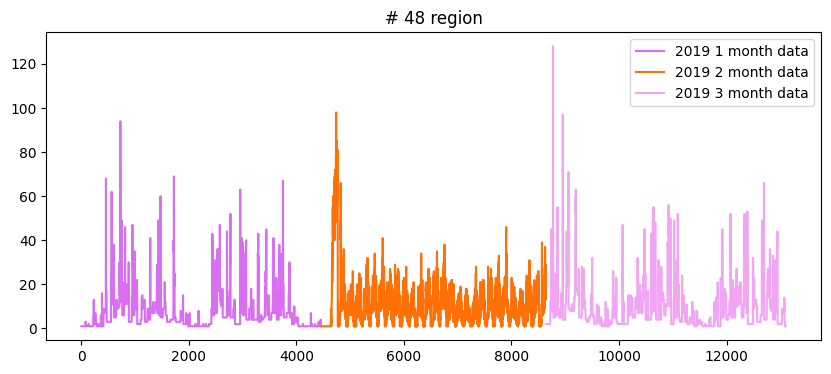

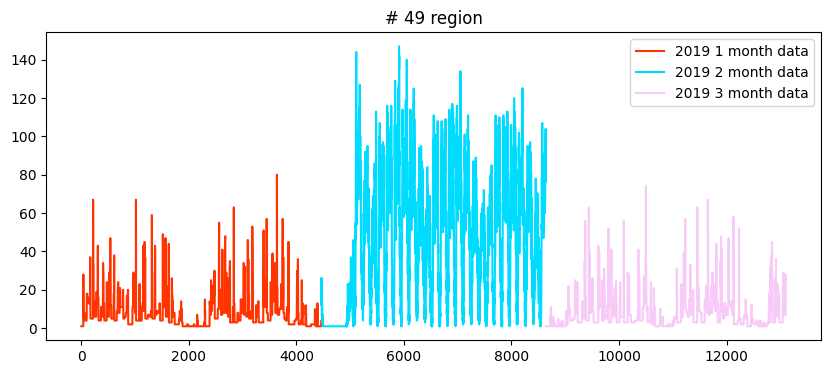

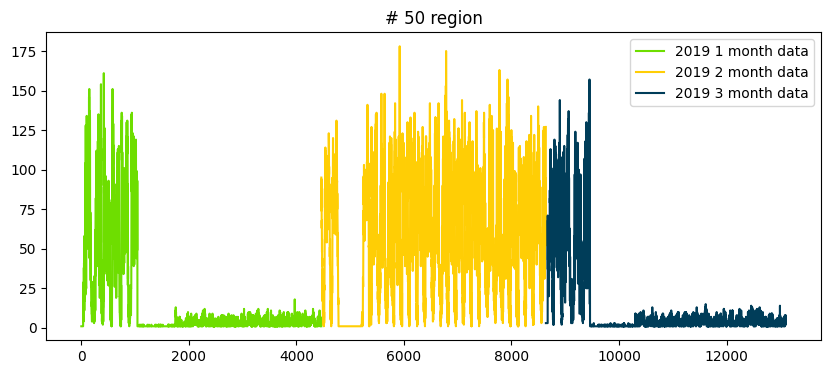

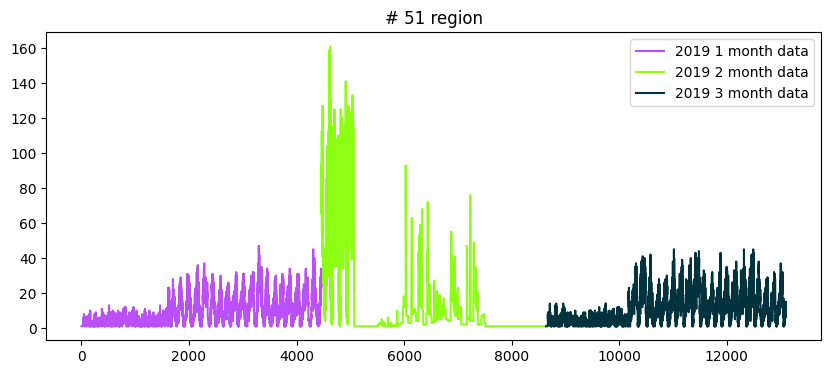

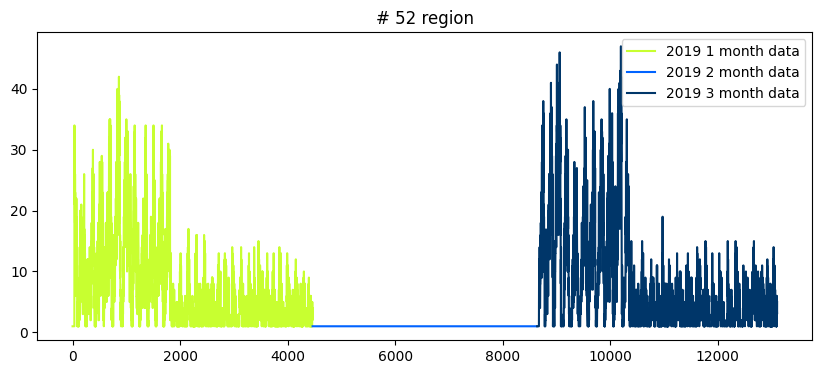

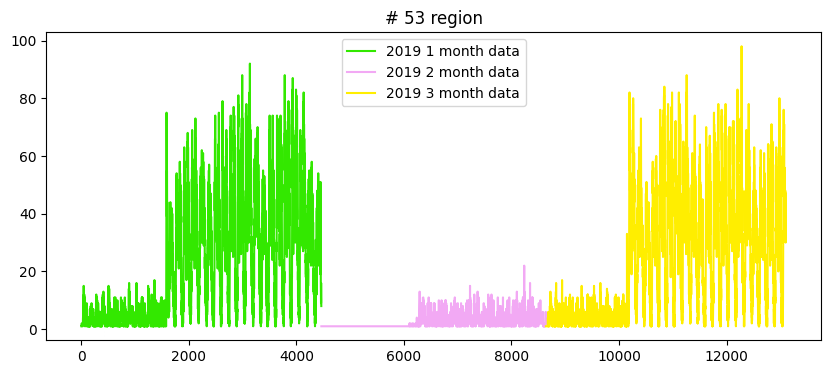

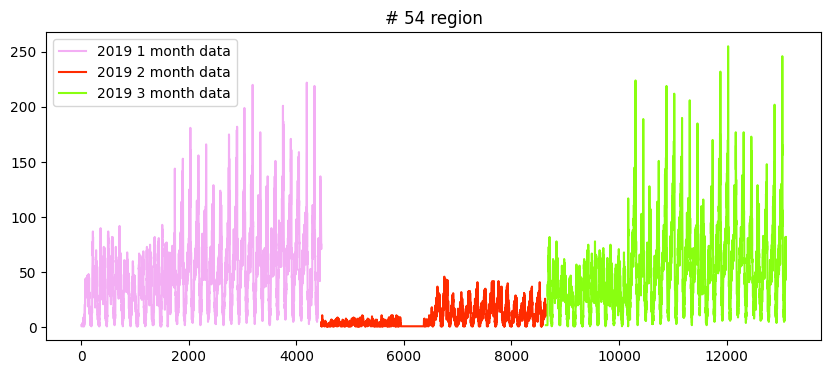

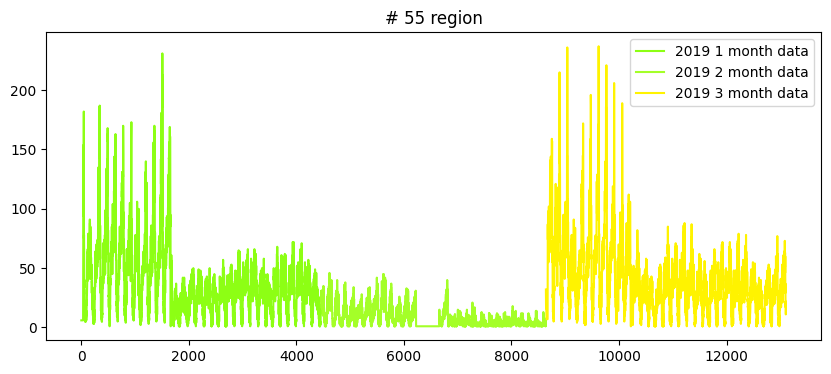

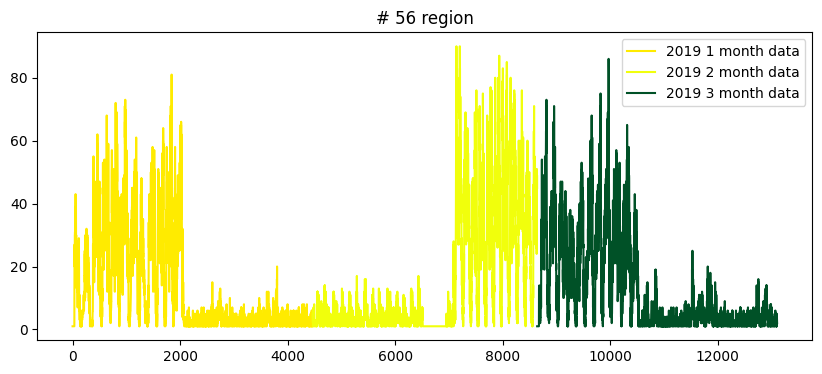

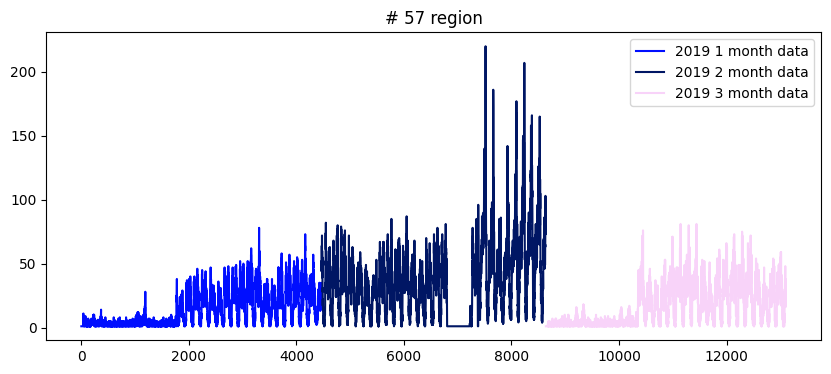

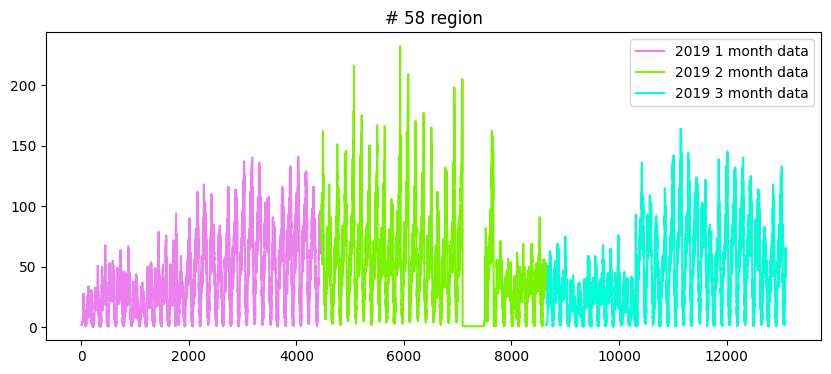

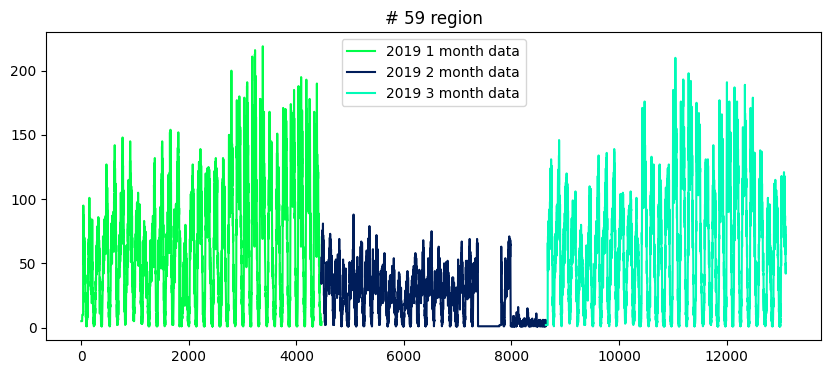

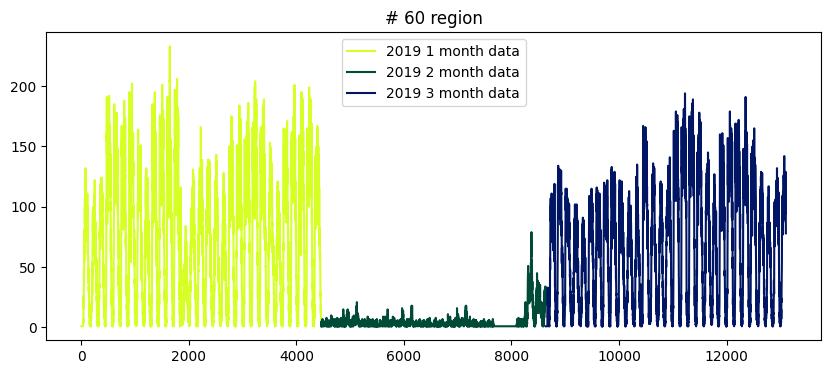

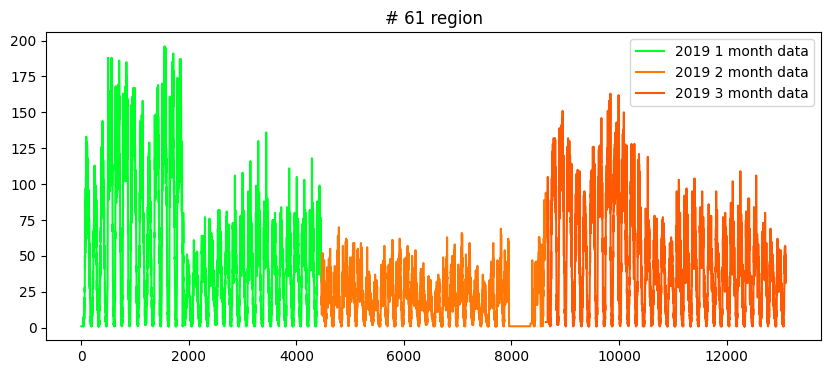

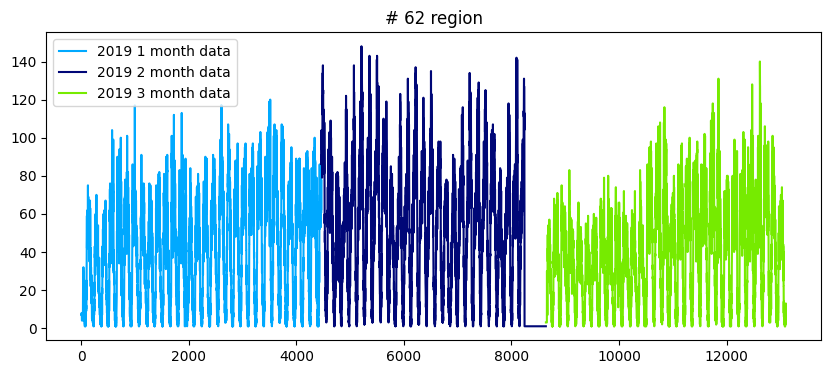

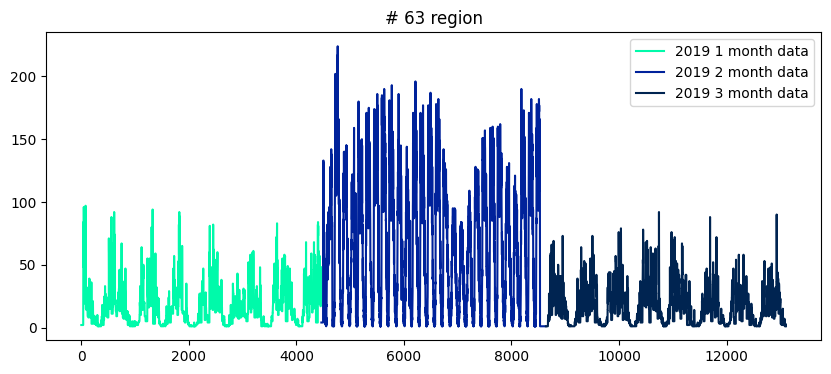

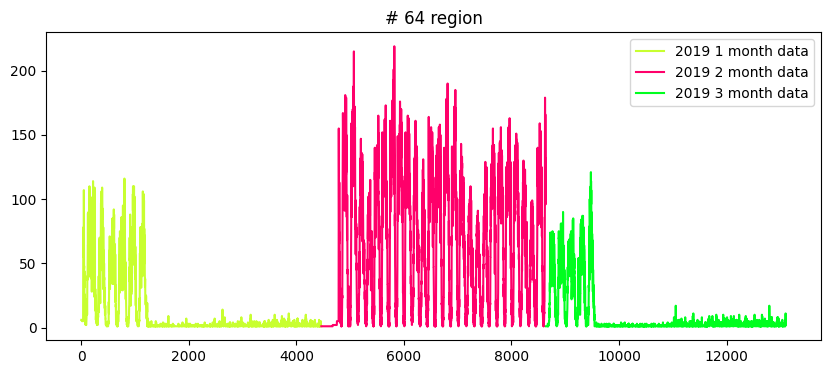

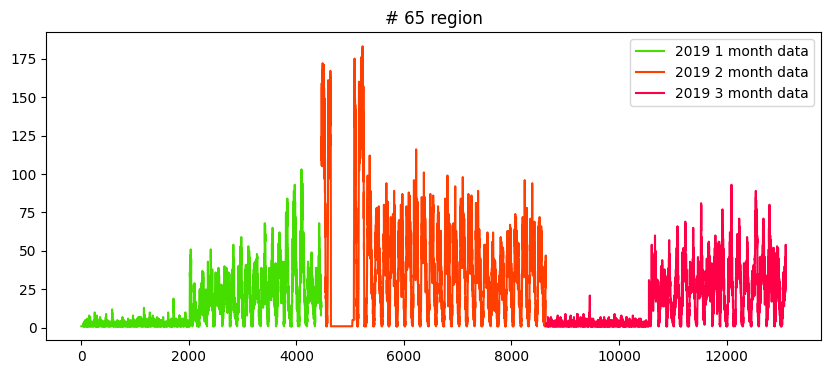

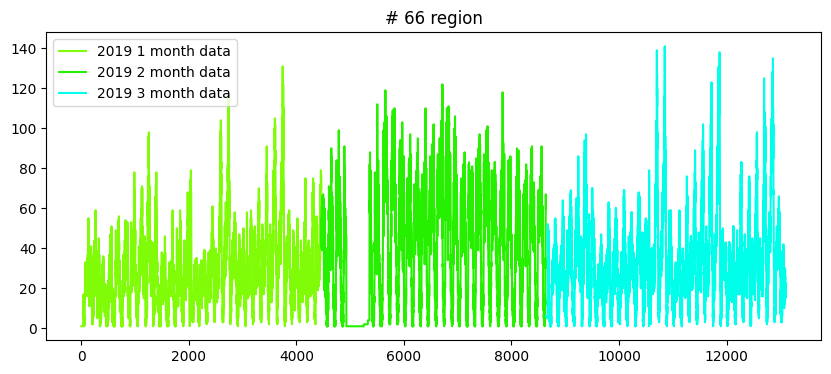

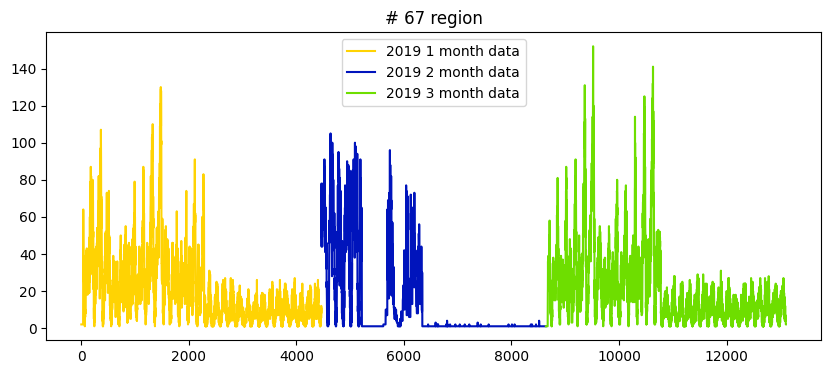

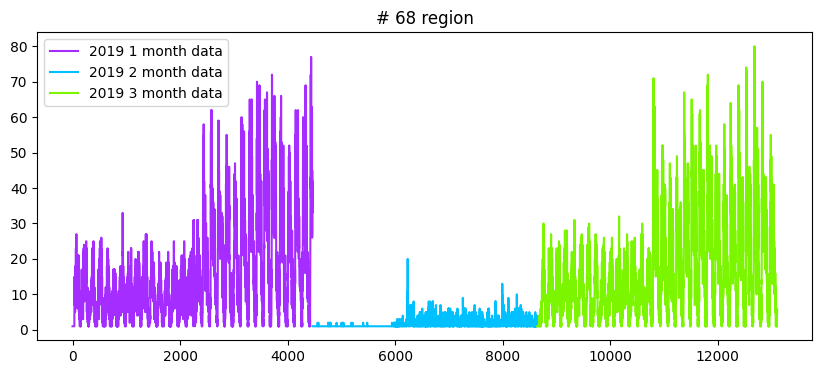

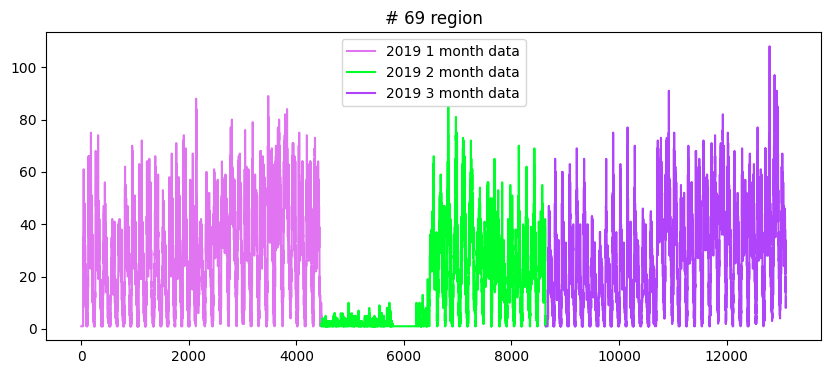

In [73]:
def uniqueish_color():
    """There're better ways to generate unique colors, but this isn't awful."""
    return plt.cm.gist_ncar(np.random.random())
x_list = []
x_list.append(list(range(0,pickup_bins_len[0])))
for i in range(1,base_month_count):
    x_list.append(list(range(sum(pickup_bins_len[:i]),sum(pickup_bins_len[:i+1]))))

# first_x = list(range(0,pickup_bins_len[0])) # 0, interval_1
# second_x = list(range(pickup_bins_len[0],sum(pickup_bins_len[0:2]))) # interval_1, inerval_1 + interval_2
# third_x = list(range(sum(pickup_bins_len[0:2]),sum(pickup_bins_len[0:3]))) # inerval_1 + interval_2, interval_1 + interval_2 + interval_3
for i in range(nyc_regions_cnt):
    plt.figure(figsize=(10,4))
    for idx, x in enumerate(x_list):
        if idx == 0:
            plt.plot(x,regions_cum[i][:pickup_bins_len[0]], color=uniqueish_color(), label=f"{base_year+1} {idx+1} month data")
        elif idx == nyc_regions_cnt-1:
            plt.plot(x,regions_cum[i][sum(pickup_bins_len[:idx]):], color=uniqueish_color(), label=f"{base_year+1} {idx+1} month data")
        else:
            plt.plot(x,regions_cum[i][sum(pickup_bins_len[:idx]):sum(pickup_bins_len[:idx+1])], color=uniqueish_color(), label=f"{base_year+1} {idx+1} month data")


    # plt.plot(first_x,regions_cum[i][:pickup_bins_len[0]], color=uniqueish_color(), label='2020 Jan month data')
    # plt.plot(second_x,regions_cum[i][pickup_bins_len[0]:sum(pickup_bins_len[0:2])], color=uniqueish_color(), label='2020 feb month data')
    # plt.plot(third_x,regions_cum[i][sum(pickup_bins_len[0:2]):], color=uniqueish_color(), label='2020 march month data')
    plt.title(f'# {i+1} region')
    plt.legend()
    plt.show()
# 그래프 해석
# title: i 번째 지역
# x축: 픽업 구간 예] 0 ~ 10 = 2020년 1월 1일 00시 00분 ~ 10분
# y축: i 번째 지역의 interval 간 픽업 발생 횟수

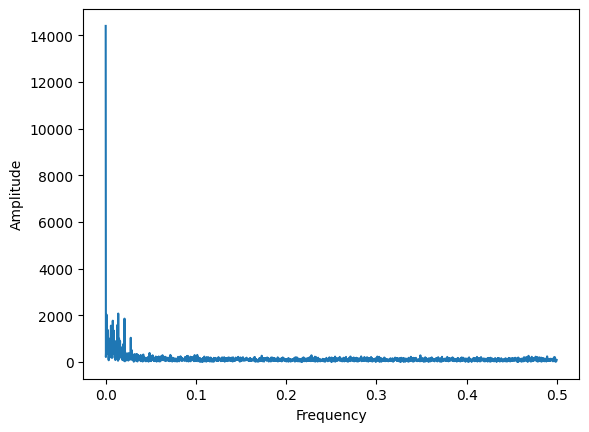

In [74]:
# getting peaks: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
# read more about fft function : https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html
# Y    = np.fft.fft(np.array(jan_2020_smooth)[0:pickup_bins_len[0]])

Y    = np.fft.fft(np.array(months_smooth[0])[:pickup_bins_len[0]])
# read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
freq = np.fft.fftfreq(pickup_bins_len[0], 1)
n = len(freq)
plt.figure()
plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

In [75]:
#Preparing the Dataframe only with x(i) values as jan-2015 data and y(i) values as jan-2016
ratios_jan = pd.DataFrame()
ratios_jan['Given']=jan_base_year_smooth
# ratios_jan['Prediction']=jan_2020_smooth
ratios_jan['Prediction']=months_smooth[0]

ratios_jan['Ratios']=ratios_jan['Prediction']*1.0/ratios_jan['Given']*1.0

In [76]:
ratios_jan.shape

(308016, 3)

# 3. Modeling

## 3-1.Simple Moving Averages

In [77]:
def MA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    error=[]
    predicted_values=[]
    window_size=3
    predicted_ratio_values=[]
    for i in range(max_pickup_bins_len*nyc_regions_cnt):
        if i%max_pickup_bins_len==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_ratio=sum((ratios['Ratios'].values)[(i+1)-window_size:(i+1)])/window_size
        else:
            predicted_ratio=sum((ratios['Ratios'].values)[0:(i+1)])/(i+1)
            
    
    ratios['MA_R_Predicted'] = predicted_values
    ratios['MA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [78]:
def MA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=1
    predicted_ratio_values=[]
    for i in range(max_pickup_bins_len*nyc_regions_cnt):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_value=int(sum((ratios['Prediction'].values)[(i+1)-window_size:(i+1)])/window_size)
        else:
            predicted_value=int(sum((ratios['Prediction'].values)[0:(i+1)])/(i+1))
            
    ratios['MA_P_Predicted'] = predicted_values
    ratios['MA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

## 3-2.Weighted Moving Averages

In [79]:
def WA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.5
    error=[]
    predicted_values=[]
    window_size=5
    predicted_ratio_values=[]
    for i in range(max_pickup_bins_len*nyc_regions_cnt):
        if i%max_pickup_bins_len==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Ratios'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Ratios'].values)[j-1]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
            
    ratios['WA_R_Predicted'] = predicted_values
    ratios['WA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [80]:
def WA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=2
    for i in range(max_pickup_bins_len*nyc_regions_cnt):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Prediction'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)

        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Prediction'].values)[j-1]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)
    
    ratios['WA_P_Predicted'] = predicted_values
    ratios['WA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

## 3-3.Exponential Weighted Moving Averages

In [81]:
def EA_R1_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.6
    error=[]
    predicted_values=[]
    predicted_ratio_values=[]
    for i in range(max_pickup_bins_len*nyc_regions_cnt):
        if i%max_pickup_bins_len==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        predicted_ratio = (alpha*predicted_ratio) + (1-alpha)*((ratios['Ratios'].values)[i])
    
    ratios['EA_R1_Predicted'] = predicted_values
    ratios['EA_R1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [82]:
def EA_P1_Predictions(ratios,month):
    predicted_value= (ratios['Prediction'].values)[0]
    alpha=0.3
    error=[]
    predicted_values=[]
    for i in range(max_pickup_bins_len*nyc_regions_cnt):
        if i%max_pickup_bins_len==0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        predicted_value =int((alpha*predicted_value) + (1-alpha)*((ratios['Prediction'].values)[i]))
    
    ratios['EA_P1_Predicted'] = predicted_values
    ratios['EA_P1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [83]:
mean_err=[0]*10
median_err=[0]*10
ratios_jan,mean_err[0],median_err[0]=MA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[1],median_err[1]=MA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[2],median_err[2]=WA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[3],median_err[3]=WA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[4],median_err[4]=EA_R1_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[5],median_err[5]=EA_P1_Predictions(ratios_jan,'jan')

# 4. Comparison between baseline models

## Regression Models

### Regression Models

In [84]:
# Preparing data to be split into train and test, The below prepares data in cumulative form which will be later split into test and train
# number of 10min indices for jan 2019= 24*31*60/10 = 4464      # pickup_bins_len[0]
# number of 10min indices for jan 2020 = 24*31*60/10 = 4464     # pickup_bins_len[0]
# number of 10min indices for feb 2020 = 24*29*60/10 = 4176     # pickup_bins_len[1]
# number of 10min indices for march 2020 = 24*31*60/10 = 4464   # pickup_bins_len[2]
# regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups 
# that are happened for three months in 2016 data

# print(len(regions_cum))
# 265
# print(len(regions_cum[0]))
# 4368


# we take number of pickups that are happened in last 5 intravels
number_of_time_stamps = 5

# output varaible
# it is list of lists
# it will contain number of pickups 4368 for each cluster
# len(regions_cum[0]) == 4368
output = []

sum(pickup_bins_len[:base_month_count])
# 우리 데이터
# len(regions_cum[0]) - 5(:= # of colunms)
# 4368 - 5 = 4363
# 13104 - 5 = 13099

# tsne_lat will contain 13104-5=13099 times lattitude of cluster center for every cluster
# Ex: [[cent_lat 13099times],[cent_lat 13099times], [cent_lat 13099times].... 40 lists]
# it is list of lists
# tsne_lat = []

# tsne_lon will contain 13104-5=13099 times logitude of cluster center for every cluster
# Ex: [[cent_long 13099times],[cent_long 13099times], [cent_long 13099times].... 40 lists]
# it is list of lists
# tsne_lon = []

# 우리는 lat, lon 대신에 목적지 ID (PULocationID: 출발지, DOLocationID: 도착지)를 사용할 것이다.
tsne_PULocationID = []

# we will code each day 
# sunday = 0, monday=1, tue = 2, wed=3, thur=4, fri=5, sat=6
# for every cluster we will be adding 13099 values, each value represent to which day of the week that pickup bin belongs to
# it is list of lists
tsne_weekday = []

# its an numbpy array, of shape (523960, 5)
# each row corresponds to an entry in out data
# for the first row we will have [f0,f1,f2,f3,f4] fi=number of pickups happened in i+1th 10min intravel(bin)
# the second row will have [f1,f2,f3,f4,f5]
# the third row will have [f2,f3,f4,f5,f6]
# and so on...
tsne_feature = []


tsne_feature = [0]*number_of_time_stamps
for i in range(1,nyc_regions_cnt+1):
    # tsne_lat.append([kmeans.cluster_centers_[i][0]]*13099) # kmeans.cluster_centers_[i][0] := Coordinates of cluster centers. 클러스트 센터의 상관계수
    # tsne_lon.append([kmeans.cluster_centers_[i][1]]*13099)

    # tsne_PULocationID
    tsne_PULocationID.append([i]*(len(regions_cum[0]) - 5))


    day_of_the_week_dict = {2015: 4, 2016: 5, 2017: 1, 2018:1, 2019:2, 2020:3, 2021:5, 2022:6}
    # jan 1st 2016 is thursday, so we start our day from 4: "(int(k/144))%7+4"
    # our prediction start from 5th 10min intravel since we need to have number of pickups that are happened in last 5 pickup bins
    
    # jan 1st 2020 is tue -> 3
    tsne_weekday.append([int(((int(k/144))%7+day_of_the_week_dict[base_year])%7) for k in range(5,sum(pickup_bins_len[:base_month_count]))])

    # jan 1st 2021 is fri -> 5
    # tsne_weekday.append([int(((int(k/144))%7+5)%7) for k in range(5,sum(pickup_bins_len[:3]))])
    # regions_cum is a list of lists [[x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], .. 40 lsits]
    
    # 우리 데이터 
    # regions_cum [[x_1,x_2,...,x_{len(regions_cum[0]) - 5}],...265 lists] len(regions_cum[0]) - 5 = 4381
    tsne_feature = np.vstack((tsne_feature, [regions_cum[i-1][r:r+number_of_time_stamps] for r in range(0,len(regions_cum[i-1])-number_of_time_stamps)]))

    output.append(regions_cum[i-1][5:])

tsne_feature = tsne_feature[1:]

In [85]:
print(tsne_feature.shape[0])
print(len(tsne_weekday)*len(tsne_weekday[0]))
print(len(output)*len(output[0]))
print(nyc_regions_cnt*(len(regions_cum[0])-5))
print(len(tsne_PULocationID)*len(tsne_PULocationID[0]))

903831
903831
903831
903831
903831


In [86]:
# Getting the predictions of exponential moving averages to be used as a feature in cumulative form

# upto now we computed 8 features for every data point that starts from 50th min of the day
# 1. cluster center lattitude
# 2. cluster center longitude
# 3. day of the week 
# 4. f_t_1: number of pickups that are happened previous t-1th 10min intravel
# 5. f_t_2: number of pickups that are happened previous t-2th 10min intravel
# 6. f_t_3: number of pickups that are happened previous t-3th 10min intravel
# 7. f_t_4: number of pickups that are happened previous t-4th 10min intravel
# 8. f_t_5: number of pickups that are happened previous t-5th 10min intravel

# from the baseline models we said the exponential weighted moving avarage gives us the best error
# we will try to add the same exponential weighted moving avarage at t as a feature to our data
# exponential weighted moving avarage => p'(t) = alpha*p'(t-1) + (1-alpha)*P(t-1) 
alpha=0.3

# it is a temporary array that store exponential weighted moving avarage for each 10min intravel, 
# for each cluster it will get reset
# for every cluster it contains 13104 values
predicted_values=[]

# it is similar like tsne_lat
# it is list of lists
# predict_list is a list of lists [[x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], .. 40 lsits]
predict_list = []
tsne_flat_exp_avg = []
for r in range(1,nyc_regions_cnt+1):
    for i in range(0,len(regions_cum[0])):
        if i==0:
            predicted_value= regions_cum[r-1][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions_cum[r-1][i]))
    predict_list.append(predicted_values[5:])
    predicted_values=[]

In [87]:
# train, test split : 70% 30% split
# Before we start predictions using the tree based regression models we take 3 months of 2016 pickup data 
# and split it such that for every region we have 70% data in train and 30% in test,
# ordered date-wise for every region

sizeof_train_data = int((len(regions_cum[0])-5)*0.7)
sizeof_test_data = int((len(regions_cum[0])-5)*0.3)


print("size of train data :", sizeof_train_data)
print("size of test data :", sizeof_test_data)

size of train data : 9169
size of test data : 3929


In [88]:
# extracting first 91nyc_regions_cnt timestamp values i.e 70% of 13099 (total timestamps) for our training data
train_features =  [tsne_feature[i*(len(regions_cum[0])-5):((len(regions_cum[0])-5)*i+sizeof_train_data)] for i in range(0,nyc_regions_cnt)]
# temp = [0]*(12955 - 9068)
test_features = [tsne_feature[((len(regions_cum[0])-5)*(i))+sizeof_train_data:(len(regions_cum[0])-5)*(i+1)] for i in range(0,nyc_regions_cnt)]

In [89]:
print("Number of data clusters",len(train_features), "Number of data points in trian data", len(train_features[0]), "Each data point contains", len(train_features[0][0]),"features")
print("Number of data clusters",len(train_features), "Number of data points in test data", len(test_features[0]), "Each data point contains", len(test_features[0][0]),"features")

Number of data clusters 69 Number of data points in trian data 9169 Each data point contains 5 features
Number of data clusters 69 Number of data points in test data 3930 Each data point contains 5 features


In [90]:
# extracting first sizeof_train_data timestamp values i.e 70% of 13099 (total timestamps) for our training data
# tsne_train_flat_lat = [i[:sizeof_train_data] for i in tsne_lat]
# tsne_train_flat_lon = [i[:sizeof_train_data] for i in tsne_lon]

tsne_train_flat_PULocationID = [i[:sizeof_train_data] for i in tsne_PULocationID]
tsne_train_flat_weekday = [i[:sizeof_train_data] for i in tsne_weekday]
tsne_train_flat_output = [i[:sizeof_train_data] for i in output]
tsne_train_flat_exp_avg = [i[:sizeof_train_data] for i in predict_list]

In [91]:
# extracting the rest of the timestamp values i.e 30% of sizeof_train_data + sizeof_test_data (total timestamps) for our test data
# tsne_test_flat_lat = [i[sizeof_train_data:] for i in tsne_lat]
# tsne_test_flat_lon = [i[sizeof_train_data:] for i in tsne_lon]

tsne_test_flat_PULocationID = [i[sizeof_train_data:] for i in tsne_PULocationID]
tsne_test_flat_weekday = [i[sizeof_train_data:] for i in tsne_weekday]
tsne_test_flat_output = [i[sizeof_train_data:] for i in output]
tsne_test_flat_exp_avg = [i[sizeof_train_data:] for i in predict_list]

In [92]:
# the above contains values in the form of list of lists (i.e. list of values of each region), here we make all of them in one list
train_new_features = []
for i in range(0,nyc_regions_cnt):
    train_new_features.extend(train_features[i])
test_new_features = []
for i in range(0,nyc_regions_cnt):
    test_new_features.extend(test_features[i])

In [93]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

# tsne_train_lat = sum(tsne_train_flat_lat, [])
# tsne_train_lon = sum(tsne_train_flat_lon, [])

tsne_train_PULocationID = sum(tsne_train_flat_PULocationID, [])
tsne_train_weekday = sum(tsne_train_flat_weekday, [])
tsne_train_output = sum(tsne_train_flat_output, [])
tsne_train_exp_avg = sum(tsne_train_flat_exp_avg,[])

In [94]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

# tsne_test_lat = sum(tsne_test_flat_lat, [])
# tsne_test_lon = sum(tsne_test_flat_lon, [])


tsne_test_PULocationID = sum(tsne_test_flat_PULocationID, [])
tsne_test_weekday = sum(tsne_test_flat_weekday, [])
tsne_test_output = sum(tsne_test_flat_output, [])
tsne_test_exp_avg = sum(tsne_test_flat_exp_avg,[])

In [95]:
# Preparing the data frame for our train data
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
df_train = pd.DataFrame(data=train_new_features, columns=columns) 
# df_train['lat'] = tsne_train_lat
# df_train['lon'] = tsne_train_lon

df_train['PULocationID'] = tsne_train_PULocationID
df_train['weekday'] = tsne_train_weekday
df_train['exp_avg'] = tsne_train_exp_avg

print(df_train.shape)

(632661, 8)


In [96]:
# Preparing the data frame for our train data
df_test = pd.DataFrame(data=test_new_features, columns=columns) 
# df_test['lat'] = tsne_test_lat
# df_test['lon'] = tsne_test_lon

df_test['PULocationID'] = tsne_test_PULocationID
df_test['weekday'] = tsne_test_weekday
df_test['exp_avg'] = tsne_test_exp_avg
print(df_test.shape)

(271170, 8)


In [97]:
df_test.head()

ft_5  ft_4  ft_3  ft_2  ft_1  PULocationID  weekday  exp_avg
0     4     4     1     1     1             1        1        1
1     4     1     1     1     1             1        1        1
2     1     1     1     1     1             1        1        1
3     1     1     1     1     3             1        1        2
4     1     1     1     3     1             1        1        1

In [98]:
print(df_test['PULocationID'].value_counts())
print(df_test['weekday'].value_counts())
print(df_test['exp_avg'].value_counts())

1     3930
45    3930
51    3930
50    3930
49    3930
      ... 
30    3930
31    3930
32    3930
33    3930
69    3930
Name: PULocationID, Length: 69, dtype: int64
2    39744
3    39744
4    39744
5    39744
6    39744
0    39744
1    32706
Name: weekday, dtype: int64
1      54220
2      21632
4      10613
5      10252
3       9344
       ...  
234        1
226        1
232        1
231        1
241        1
Name: exp_avg, Length: 233, dtype: int64


## Using Linear Regression

In [99]:
# find more about LinearRegression function here http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
# -------------------------
# default paramters
# sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)

# some of methods of LinearRegression()
# fit(X, y[, sample_weight])	Fit linear model.
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict using the linear model
# score(X, y[, sample_weight])	Returns the coefficient of determination R^2 of the prediction.
# set_params(**params)	Set the parameters of this estimator.
# -----------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1-2-copy-8/
# -----------------------

from sklearn.linear_model import LinearRegression
lr_reg=LinearRegression().fit(df_train, tsne_train_output)

y_pred = lr_reg.predict(df_test)
lr_test_predictions = [round(value) for value in y_pred]
y_pred = lr_reg.predict(df_train)
lr_train_predictions = [round(value) for value in y_pred]

## Using Random Forest Regressor

In [100]:
# Training a hyper-parameter tuned random forest regressor on our train data
# find more about LinearRegression function here http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
# -------------------------
# default paramters
# sklearn.ensemble.RandomForestRegressor(n_estimators=10, criterion=’mse’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False)

# some of methods of RandomForestRegressor()
# apply(X)	Apply trees in the forest to X, return leaf indices.
# decision_path(X)	Return the decision path in the forest
# fit(X, y[, sample_weight])	Build a forest of trees from the training set (X, y).
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict regression target for X.
# score(X, y[, sample_weight])	Returns the coefficient of determination R^2 of the prediction.
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

regr1 = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=40, n_jobs=-1)
regr1.fit(df_train, tsne_train_output)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=3, n_estimators=40, n_jobs=-1)

In [101]:
# Predicting on test data using our trained random forest model 

# the models regr1 is already hyper parameter tuned
# the parameters that we got above are found using grid search

y_pred = regr1.predict(df_test)
rndf_test_predictions = [round(value) for value in y_pred]
y_pred = regr1.predict(df_train)
rndf_train_predictions = [round(value) for value in y_pred]

In [102]:
#feature importances based on analysis using random forest
print (df_train.columns)
print (regr1.feature_importances_)

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'PULocationID', 'weekday',
       'exp_avg'],
      dtype='object')
[0.04939214 0.14196541 0.14811928 0.1367379  0.17226404 0.00567957
 0.00250865 0.34333302]


## Using XgBoost Regressor

In [103]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBRegressor function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#module-xgboost.sklearn
# -------------------------
# default paramters
# xgboost.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear', 
# booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, 
# colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, 
# missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

x_model = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 reg_alpha=200, reg_lambda=200,
 colsample_bytree=0.8,nthread=4)
x_model.fit(df_train, tsne_train_output)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=3,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=4, nthread=4, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=200, ...)

In [104]:
#predicting with our trained Xg-Boost regressor
# the models x_model is already hyper parameter tuned
# the parameters that we got above are found using grid search

y_pred = x_model.predict(df_test)
xgb_test_predictions = [round(value) for value in y_pred]
y_pred = x_model.predict(df_train)
xgb_train_predictions = [round(value) for value in y_pred]

In [105]:
#feature importances
x_model.get_booster().get_score(importance_type="weight")

{'ft_5': 941.0,
 'ft_4': 842.0,
 'ft_3': 855.0,
 'ft_2': 1061.0,
 'ft_1': 1095.0,
 'PULocationID': 1016.0,
 'weekday': 179.0,
 'exp_avg': 900.0}

## Calculating the error metric values for various models

In [106]:
train_R2=[]
test_R2=[]

train_R2.append(r2_score(tsne_train_output,df_train['ft_1'].values))
train_R2.append(r2_score(tsne_train_output,df_train['exp_avg'].values))
train_R2.append(r2_score(tsne_train_output,rndf_train_predictions))
train_R2.append(r2_score(tsne_train_output,xgb_train_predictions))
train_R2.append(r2_score(tsne_train_output,lr_train_predictions))

test_R2.append(r2_score(tsne_test_output,df_test['ft_1'].values))
test_R2.append(r2_score(tsne_test_output,df_test['exp_avg'].values))
test_R2.append(r2_score(tsne_test_output,rndf_test_predictions))
test_R2.append(r2_score(tsne_test_output,xgb_test_predictions))
test_R2.append(r2_score(tsne_test_output,lr_test_predictions))


In [107]:
print(f"{base_year+1} 1 ~ {base_month_count} {region} R2")
print ("--------------------------------------------------------------------------------------------------------")
print ("Baseline Model\t\t\t","Train: ",train_R2[0],"Test: ",test_R2[0],sep='\t')
print ("Exponential Averages Forecasting","Train: ",train_R2[1],"Test: ",test_R2[1],sep='\t')
print ("Random Forest Regression\t","Train: ",train_R2[2],"Test: ",test_R2[2],sep='\t')
print ("XgBoost Regression\t\t","Train: ",train_R2[3],"Test: ",test_R2[3],sep='\t')
print ("Linear Regression\t\t","Train: ",train_R2[4],"Test: ",test_R2[4],sep='\t')


2019 1 ~ 3 Manhattan R2
--------------------------------------------------------------------------------------------------------
Baseline Model				Train: 	0.9280028483795424	Test: 	0.9294204703959716
Exponential Averages Forecasting	Train: 	0.9360225573665514	Test: 	0.9376843770266051
Random Forest Regression		Train: 	0.9652545379954185	Test: 	0.9403721618719519
XgBoost Regression			Train: 	0.9415925567621993	Test: 	0.9411079155802181
Linear Regression			Train: 	0.9374472265944981	Test: 	0.9390473134862812


In [108]:
train_MAE=[]
test_MAE=[]
train_MAE.append(mean_absolute_error(tsne_train_output,df_train['ft_1'].values))
train_MAE.append(mean_absolute_error(tsne_train_output,df_train['exp_avg'].values))
train_MAE.append(mean_absolute_error(tsne_train_output,rndf_train_predictions))
train_MAE.append(mean_absolute_error(tsne_train_output,xgb_train_predictions))
train_MAE.append(mean_absolute_error(tsne_train_output,lr_train_predictions))

test_MAE.append(mean_absolute_error(tsne_test_output,df_test['ft_1'].values))
test_MAE.append(mean_absolute_error(tsne_test_output,df_test['exp_avg'].values))
test_MAE.append(mean_absolute_error(tsne_test_output,rndf_test_predictions))
test_MAE.append(mean_absolute_error(tsne_test_output,xgb_test_predictions))
test_MAE.append(mean_absolute_error(tsne_test_output,lr_test_predictions))

In [109]:
print(f"{base_year+1} 1 ~ {base_month_count} {region} MAE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Baseline Model\t\t\t","Train: ",train_MAE[0],"Test: ",test_MAE[0],sep='\t')
print ("Exponential Averages Forecasting","Train: ",train_MAE[1],"Test: ",test_MAE[1],sep='\t')
print ("Random Forest Regression\t","Train: ",train_MAE[2],"Test: ",test_MAE[2],sep='\t')
print ("XgBoost Regression\t\t","Train: ",train_MAE[3],"Test: ",test_MAE[3],sep='\t')
print ("Linear Regression\t\t","Train: ",train_MAE[4],"Test: ",test_MAE[4],sep='\t')

2019 1 ~ 3 Manhattan MAE
--------------------------------------------------------------------------------------------------------
Baseline Model				Train: 	4.215717422126541	Test: 	4.484747575321754
Exponential Averages Forecasting	Train: 	3.9742705809272265	Test: 	4.22598001253826
Random Forest Regression		Train: 	2.963065527984181	Test: 	4.174130619168787
XgBoost Regression			Train: 	3.8632790704658575	Test: 	4.149312239554523
Linear Regression			Train: 	3.9556318470713383	Test: 	4.2028469225946825


In [1]:
import folium
from folium import features
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster

taxi_map = folium.Map(location=[40.742459, -73.971765], zoom_start=12)
taxi_map
